In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import astropy
from astropy.io import ascii
import lmfit
from lmfit import Model
import scipy.stats
import emcee 
import corner
import ultranest 
from ultranest.plot import cornerplot

##  Modified black body (Planck) fitting to dust emission 


In [4]:
### Far infrared emission from a galaxy, to be modelled with a modified Planck law

data_array=np.array([   
[59.96,1.16e+43,1.14e+41],
[70.04,1.88e+43,1.07e+42],
[71.34,1.73e+43,9.92e+41],
[99.93,2.11e+43,1.14e+42],
[156.1,1.83e+43,1.29e+42],
[160.3,1.63e+43,8.49e+41],
[249.8,4.36e+42,3.36e+41],
[349.8,1.34e+42,1.23e+41],
[499.7,3.71e+41,6.04e+40]
])

x_data,y_data,y_data_err = data_array[:,0], data_array[:,1], data_array[:,2]

### The modelling function: A modified black body 


#### Grey (or modified black) Body emission from dust grains
The monochromatic energy flux from a surface element of a sphere, in a direction normal to this element, can be obtained from Planck's law: $F_\lambda = \pi B_\lambda$ (e.g., Rybicki \& Lightman). Let the sphere be a single dust grain. The black body luminosity detected from a heated dust grain is then obtained by integrating the flux from all elements of its surface: $4\pi a_g^2 \pi B_\lambda$, where $a_g$ is its radius. As the grain may be somewhat less efficient in its emission by a pure black body, its emission can instead be described as

$B^{modified}_\lambda (T) = Q_{em}(\lambda)  B^{Planck}_\lambda (T)$, where $Q_{em}(\lambda)$ is called the emissivity (Hildebrand 1983). The emissivity encapsulates the deviation in the emission efficiency from that of a pure black body and it is equal to the ratio of the emitting cross section to the geometrical cross section. It depends on λ as: 

$ 
Q_{em}(\lambda) = Q_{ref} \left( \frac{ \lambda_{ref}}{\lambda} \right)^\beta = \frac{1}{507} \left(\frac{\lambda_{ref}}{\lambda}\right)^{2}, 
$ (Bianchi et al. 1999,Whittet 1992).

Conservation of energy and thus of luminosity (=E/s), whether measured from the grain surface of from the Earth, implies that $4\pi D^2 F_\lambda$ = $4\pi a_g^2 \pi B_\lambda$, where D is the distance of the galaxy that hosts the grain. Multiplying with the number of grains N, the flux that we detect from the galaxy is: 

$  F_\lambda =  N\,[a_g^2 / D^2] \pi Q_{em}(\lambda)  B^{Planck}_\lambda (T)$. So by substituting $B^{Planck}$, we get

$
F_{\lambda}   =  N\left( \frac{a_g^2}{D^2} \right) \frac{\pi}{507} \left(\frac{100 \mu m}{\lambda}\right)^{2}  \frac{2hc^2}{\lambda^5} \frac{1}{e^{(hc/\lambda k_BT)}-1}
$

for the flux or, for the luminosity,

$
L_{\lambda}  =  N a_g^2 \left(\frac{4π^2}{507}\right)\left(\frac{100 \mu m}{\lambda}\right)^{2}  \frac{2hc^2}{\lambda^5} \frac{1}{e^{(hc/\lambda k_BT)}-1}
$


We can replace $N a_g^2$ via the total dust mass,
$M = N m_{grain} = N \rho_g \frac{4 \pi a_{g}^3}{3} = Na_{g}^2 \rho_g \frac{4 \pi a_{g}}{3} $, where for a typical grain the density $\rho_g$=2.7 $gr / cm^{3}$ and $a_g$=1 $\mu$m. Finally, by multiplying both sides with λ, we get

$$
\lambda L_\lambda (T,M) = \frac{M}{ a_g \rho_g} \frac{6\pi}{507} \left(\frac{100 \mu m}{\lambda}\right)^{2} \frac{1}{\lambda^4}\frac{hc^2}{e^{(hc/\lambda k_BT)}-1} = 1.8 \times 10^{35} M \left(\frac{100 \mu m}{\lambda}\right)^{2} \frac{1}{\lambda^4}\frac{1}{e^{(14388/\lambda T)}-1}[erg/s],
$$

for the modified black body luminosity, with M in solar masses, T in K, and $\lambda$ in $\mu$m. So, we end up with a function of only 2 free parameters: the dust temperature and mass







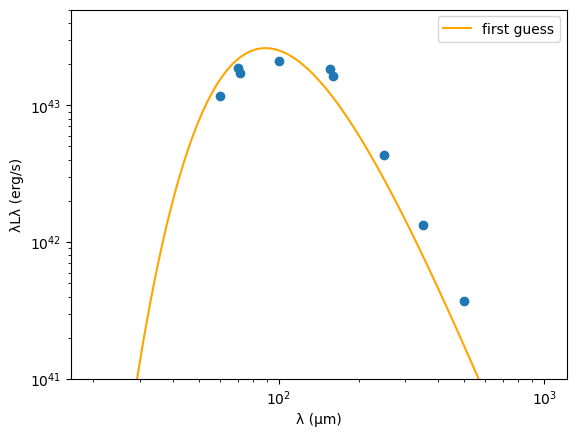

In [5]:
#Modified black body function    

def grey_body_luminosity(wavelength,T, logMd): #wavelength in μm
    h,c, kb, Lodot, Modot = 6.626e-27 ,3e10 , 1.38e-16 ,3.9e33 , 2.0e33
    ag = 0.1*10**-4 #cm 
    rhog = 2.7 #gr/cm^3        

    lambda_cm = wavelength/1e4 #frequencies in Hz
    lambdaB_lambda = (2*h*c**2)*1/(lambda_cm)**4*1/(np.exp(h*c/kb/T/lambda_cm)-1)

    Q = (1./507.)*(100./wavelength)**2 
    lambdaL_lambda = (3*np.pi*((10**logMd)*Modot)/ag/rhog) * Q*lambdaB_lambda
         
    return_value=lambdaL_lambda

    return return_value


# A rough attempt by hand, together with the best fit result from the chi^2 minimization
plt.scatter(x_data,y_data)
plt.ylabel('λLλ (erg/s)') 
plt.xlabel('λ (μm)') 
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e41,5e43])

xaxis=np.linspace(20,1000,1000)
plt.plot(xaxis,grey_body_luminosity(xaxis,27, 6.5),color='orange',label='first guess')
#plt.plot(xaxis,grey_body_luminosity(xaxis,chi2_values_fit[0],chi2_values_fit[1]),color='darkviolet',label='chi^2')
#plt.plot(xaxis,grey_body_luminosity(xaxis,prob_values_fit[0],prob_values_fit[1]),color='lightblue',label='-ln(probability)')

plt.legend()


In [6]:
# first, a chi^2 solution
#Calculate the chi2 function FOR A SINGLE MODEL, CONSTRUCTED WITH A GIVEN SET OF PARAMETERS

def calc_chi2(params,model_function, data_x, data_y, data_y_err):
    model_y = model_function(data_x, *params) #parameters must be provided in the correct order
    chi2 = np.sum((model_y - data_y)**2 /(data_y_err)**2)
    return  chi2

#Run Minimizer (can also use other functions)
sol = minimize(calc_chi2, [30,7], args=(grey_body_luminosity, x_data,y_data,y_data_err), bounds  = [ [10, 100] , [4.0, 11.0] ],tol=1e-15)

chi2_values_fit =  sol.x
#T_fit, logMd_fit = np.round(sol.x,4)

print("T=",chi2_values_fit[0],"mass=",10**chi2_values_fit[1])

T= 24.544995138681376 mass= 5801213.100215218


#### Now, let's solve it with probabilities, but first define all priors
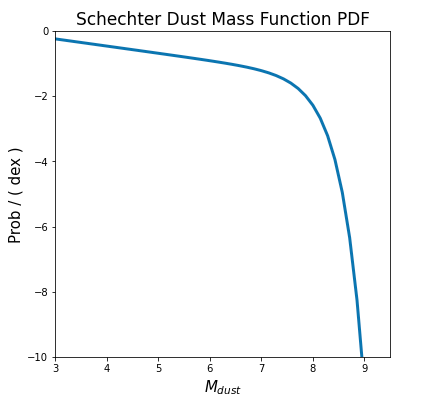

In [7]:
def mass_function(logMd):
    M = 10**logMd
    return 5.36e-2*(M/4.65e7)**(-0.22)*np.exp(-M/4.65e7)

In [8]:
## probabilities:
#Calculate the probability FOR A SINGLE MODEL, CONSTRUCTED WITH A GIVEN SET OF PARAMETERS

def ln_priors_grey_body(params):
    expected_value=40.
    sigma_around_expected_value=1.
    ln_prior_on_T =  - 0.5* (params[0]-expected_value)**2/(2*sigma_around_expected_value**2) - 0.5 *np.log( 2*np.pi*sigma_around_expected_value**2 ) 
    ln_prior_on_M = np.log( mass_function(params[1]) )
    return ln_prior_on_T + ln_prior_on_M

def ln_likelihood_grey_body(params, x, y, dy):
    y_model = grey_body_luminosity(x, params[0], params[1])
    like=-0.5 * np.sum((y-y_model)**2 / dy**2 ) -np.sum(np.log(2*np.pi*dy**2))
    if np.isnan(like):
        return -np.inf
    else:
        return like
    
def ln_posterior_grey_body(params, x, y,dy):
   # return ln_likelihood_grey_body(params, x, y, dy)  
    return ln_priors_grey_body(params) + ln_likelihood_grey_body(params, x, y, dy)  

def minus_ln_posterior_grey_body(params, x, y,dy):
   # return -ln_likelihood_grey_body(params, x, y, dy) 
     return -(ln_likelihood_grey_body(params, x, y, dy) + ln_priors_grey_body(params)  )



In [9]:
# First let's see the results without walkers in the parameter space, but with a chi^2 minimization with added priors
# Indeed, adding priors changes the results !

sol = minimize(minus_ln_posterior_grey_body, [30,7], args=(x_data,y_data,y_data_err), bounds  = [ [10, 100] , [4.0, 11.0] ],tol=1e-15)

prob_values_fit =  sol.x
#T_fit, logMd_fit = np.round(sol.x,4)

print("T=",prob_values_fit[0],"mass=",10**prob_values_fit[1])


T= 39.192899459423785 mass= 130944.25488361447


C:\Users\MargaritisX\AppData\Local\Temp\ipykernel_11676\1459718789.py:8: RuntimeWarning: divide by zero encountered in log
  ln_prior_on_M = np.log( mass_function(params[1]) )
C:\Users\MargaritisX\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


#### Now with a Markov Chain Monte Carlo + Bayesian

#### Warning: This code snippet taken from the lecture sometimes does not work correctly. We need to rerun it for the emcee method to give correct results.

C:\Users\MargaritisX\AppData\Local\Temp\ipykernel_11676\1459718789.py:8: RuntimeWarning: divide by zero encountered in log
  ln_prior_on_M = np.log( mass_function(params[1]) )
C:\Users\MargaritisX\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
C:\Users\MargaritisX\AppData\Local\Temp\ipykernel_11676\678785235.py:9: RuntimeWarning: overflow encountered in exp
  lambdaB_lambda = (2*h*c**2)*1/(lambda_cm)**4*1/(np.exp(h*c/kb/T/lambda_cm)-1)



 Mean T bayesian =   26.003724819576767 
 Mean mass bayesian =   4557082.079465342


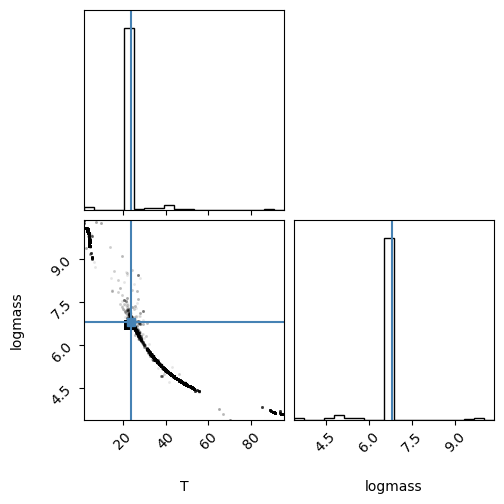

In [10]:
# emcee combines MCMC chains (walkers) of a number of steps.

ndim = 2  # number of parameters in the model
nwalkers = 100  # number of MCMC walkers
nburn = 20# "burn-in" period to stabilise chains
nsteps = 2000  # number of MCMC steps to take


#starting_guesses = np.random.random((nwalkers, ndim)) # random positioning of 50 walkers in parameter space
#starting_guesses[:,0]*=10
# starting_guesses[:,1]=(starting_guesses[:,1]*5+6)
starting_guesses=np.random.normal([30,8],[7,2],size=(nwalkers, ndim))


sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior_grey_body, args=[x_data, y_data,y_data_err])
sampler.run_mcmc(starting_guesses, nsteps)
emcee_trace = sampler.get_chain(discard=nburn,flat=True) 

previous_solution=[24,6.8]


fig = corner.corner(emcee_trace, labels=['T','logmass'],truths=[previous_solution[0], previous_solution[1]]);

print( '\n Mean T bayesian =  ', emcee_trace[:,0].mean(),
     '\n Mean mass bayesian =  ', 10.**emcee_trace[:,1].mean())

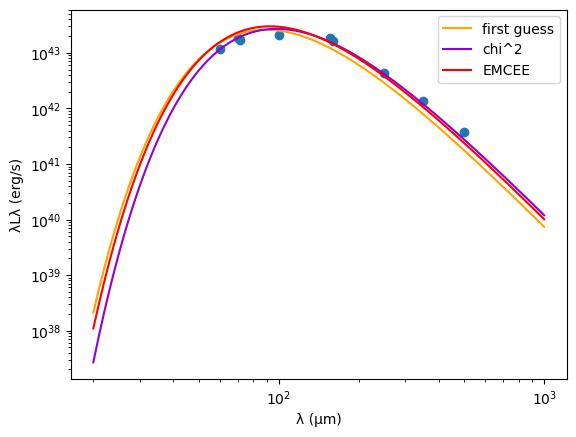

In [11]:
plt.scatter(x_data,y_data)
plt.ylabel('λLλ (erg/s)') 
plt.xlabel('λ (μm)') 
plt.yscale('log')
plt.xscale('log')


xaxis=np.linspace(20,1000,1000)
plt.plot(xaxis,grey_body_luminosity(xaxis,27, 6.5),color='orange',label='first guess')
plt.plot(xaxis,grey_body_luminosity(xaxis,chi2_values_fit[0],chi2_values_fit[1]),color='darkviolet',label='chi^2')
plt.plot(xaxis,grey_body_luminosity(xaxis,emcee_trace[:,0].mean(),emcee_trace[:,1].mean()),color='red',label='EMCEE')

plt.legend()

## UltraNest

In [12]:
def ln_likelihood_grey_body(params, x, y, dy):
    y_model = grey_body_luminosity(x, params[0], params[1])
    like = -0.5 * np.sum((y - y_model) ** 2 / dy ** 2) - np.sum(np.log(2 * np.pi * dy ** 2))
    if np.isnan(like):
        return -np.inf
    else:
        return like



def log_likelihood(params):
    return ln_likelihood_grey_body(params, x_data, y_data, y_data_err)

#Linear
# def prior_transform(cube):
#     params = np.zeros(2)
#     params[0] = cube[0] * 70. + 30.  # Prior on T
#     params[1] = cube[1] * 7. + 1.  # Prior on logmass
#     return params

#Gaussian (gives better results)
def prior_transform(cube):
    params = np.zeros(2)
    
    center_T = 25.0
    center_logmass = 7.0
    
    std_T = 5.0
    std_logmass = 0.5
    
    params[0] = scipy.stats.norm.ppf(cube[0], loc=center_T, scale=std_T)
    params[1] = scipy.stats.norm.ppf(cube[1], loc=center_logmass, scale=std_logmass)
    
    return params

In [13]:
sampler = ultranest.ReactiveNestedSampler(
    param_names=['T', 'logmass'],
    loglike=log_likelihood,
    transform=prior_transform,
    log_dir="ultranest_output",
    resume=True
)
# result.run(max_num_samples=2000, dlogz=0.1)
result = sampler.run(min_num_live_points=100, min_ess=1000)
sampler.print_results()

DEBUG:ultranest:ReactiveNestedSampler: dims=2+0, resume=True, log_dir=ultranest_output, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 100 live points from prior ...


INFO:ultranest:Sampling 100 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=1000
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=100, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 100.0), (inf, 100.0)]


DEBUG:ultranest:iteration=0, ncalls=101, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-538094541.50, Lmax=-1941.27


DEBUG:ultranest:iteration=10, ncalls=112, regioncalls=480, ndraw=40, logz=-2614645.80, remainder_fraction=100.0000%, Lmin=-2458037.90, Lmax=-1941.27


DEBUG:ultranest:iteration=20, ncalls=125, regioncalls=1000, ndraw=40, logz=-1317793.63, remainder_fraction=100.0000%, Lmin=-1284694.60, Lmax=-1941.27


DEBUG:ultranest:iteration=23, ncalls=129, regioncalls=1160, ndraw=40, logz=-1162074.20, remainder_fraction=100.0000%, Lmin=-1023461.40, Lmax=-1941.27


DEBUG:ultranest:iteration=30, ncalls=138, regioncalls=1520, ndraw=40, logz=-358947.61, remainder_fraction=100.0000%, Lmin=-331383.06, Lmax=-1932.56


DEBUG:ultranest:iteration=40, ncalls=149, regioncalls=1960, ndraw=40, logz=-137748.40, remainder_fraction=100.0000%, Lmin=-136859.51, Lmax=-1932.56


DEBUG:ultranest:iteration=50, ncalls=159, regioncalls=2360, ndraw=40, logz=-64183.72, remainder_fraction=100.0000%, Lmin=-53584.72, Lmax=-1770.46


DEBUG:ultranest:iteration=60, ncalls=177, regioncalls=3080, ndraw=40, logz=-24702.23, remainder_fraction=100.0000%, Lmin=-19669.64, Lmax=-1770.46


DEBUG:ultranest:iteration=69, ncalls=187, regioncalls=3480, ndraw=40, logz=-9831.06, remainder_fraction=100.0000%, Lmin=-9173.07, Lmax=-1770.46


DEBUG:ultranest:iteration=70, ncalls=188, regioncalls=3520, ndraw=40, logz=-9178.37, remainder_fraction=100.0000%, Lmin=-8462.87, Lmax=-1770.46


DEBUG:ultranest:iteration=80, ncalls=201, regioncalls=4040, ndraw=40, logz=-7716.97, remainder_fraction=100.0000%, Lmin=-7653.21, Lmax=-1770.46


DEBUG:ultranest:iteration=90, ncalls=214, regioncalls=4560, ndraw=40, logz=-7453.31, remainder_fraction=100.0000%, Lmin=-7438.55, Lmax=-1770.46


DEBUG:ultranest:iteration=92, ncalls=216, regioncalls=4640, ndraw=40, logz=-7443.07, remainder_fraction=100.0000%, Lmin=-7338.74, Lmax=-1770.46


DEBUG:ultranest:iteration=100, ncalls=226, regioncalls=5040, ndraw=40, logz=-6783.12, remainder_fraction=100.0000%, Lmin=-6704.90, Lmax=-1770.46


DEBUG:ultranest:iteration=110, ncalls=237, regioncalls=5480, ndraw=40, logz=-6466.10, remainder_fraction=100.0000%, Lmin=-6417.99, Lmax=-1770.46


DEBUG:ultranest:iteration=115, ncalls=244, regioncalls=5760, ndraw=40, logz=-6228.25, remainder_fraction=100.0000%, Lmin=-6206.78, Lmax=-1770.46


DEBUG:ultranest:iteration=120, ncalls=252, regioncalls=6080, ndraw=40, logz=-6145.66, remainder_fraction=100.0000%, Lmin=-6066.53, Lmax=-1770.46


DEBUG:ultranest:iteration=130, ncalls=263, regioncalls=6560, ndraw=40, logz=-5565.43, remainder_fraction=100.0000%, Lmin=-5478.41, Lmax=-1770.46


DEBUG:ultranest:iteration=138, ncalls=275, regioncalls=7120, ndraw=40, logz=-5063.09, remainder_fraction=100.0000%, Lmin=-4933.26, Lmax=-1770.46


DEBUG:ultranest:iteration=140, ncalls=278, regioncalls=7240, ndraw=40, logz=-4913.22, remainder_fraction=100.0000%, Lmin=-4863.45, Lmax=-1770.46


DEBUG:ultranest:iteration=150, ncalls=292, regioncalls=7800, ndraw=40, logz=-4349.25, remainder_fraction=100.0000%, Lmin=-4254.74, Lmax=-1770.46


DEBUG:ultranest:iteration=160, ncalls=306, regioncalls=8360, ndraw=40, logz=-3946.97, remainder_fraction=100.0000%, Lmin=-3919.16, Lmax=-1770.46


DEBUG:ultranest:iteration=170, ncalls=323, regioncalls=9120, ndraw=40, logz=-3688.90, remainder_fraction=100.0000%, Lmin=-3572.44, Lmax=-1770.46


DEBUG:ultranest:iteration=180, ncalls=340, regioncalls=9840, ndraw=40, logz=-3414.51, remainder_fraction=100.0000%, Lmin=-3378.00, Lmax=-1770.46


DEBUG:ultranest:iteration=190, ncalls=353, regioncalls=10360, ndraw=40, logz=-3144.92, remainder_fraction=100.0000%, Lmin=-3134.53, Lmax=-1770.46


DEBUG:ultranest:iteration=200, ncalls=374, regioncalls=11200, ndraw=40, logz=-3021.05, remainder_fraction=100.0000%, Lmin=-3011.72, Lmax=-1770.46


DEBUG:ultranest:iteration=210, ncalls=393, regioncalls=12040, ndraw=40, logz=-2835.38, remainder_fraction=100.0000%, Lmin=-2821.89, Lmax=-1770.46


DEBUG:ultranest:iteration=220, ncalls=417, regioncalls=13160, ndraw=40, logz=-2778.72, remainder_fraction=100.0000%, Lmin=-2770.25, Lmax=-1770.46


DEBUG:ultranest:iteration=230, ncalls=438, regioncalls=14080, ndraw=40, logz=-2664.46, remainder_fraction=100.0000%, Lmin=-2650.60, Lmax=-1770.46


DEBUG:ultranest:iteration=240, ncalls=459, regioncalls=14920, ndraw=40, logz=-2588.93, remainder_fraction=100.0000%, Lmin=-2575.26, Lmax=-1770.46


DEBUG:ultranest:iteration=250, ncalls=494, regioncalls=16480, ndraw=40, logz=-2476.64, remainder_fraction=100.0000%, Lmin=-2455.34, Lmax=-1763.61


DEBUG:ultranest:iteration=260, ncalls=515, regioncalls=17440, ndraw=40, logz=-2419.56, remainder_fraction=100.0000%, Lmin=-2402.44, Lmax=-1763.61


DEBUG:ultranest:iteration=270, ncalls=533, regioncalls=18560, ndraw=40, logz=-2307.01, remainder_fraction=100.0000%, Lmin=-2295.90, Lmax=-1763.61


DEBUG:ultranest:iteration=280, ncalls=574, regioncalls=20440, ndraw=40, logz=-2218.10, remainder_fraction=100.0000%, Lmin=-2198.09, Lmax=-1763.61


DEBUG:ultranest:iteration=290, ncalls=603, regioncalls=21880, ndraw=40, logz=-2128.91, remainder_fraction=100.0000%, Lmin=-2120.40, Lmax=-1763.61


DEBUG:ultranest:iteration=300, ncalls=636, regioncalls=23280, ndraw=40, logz=-2106.10, remainder_fraction=100.0000%, Lmin=-2095.92, Lmax=-1763.61


DEBUG:ultranest:iteration=310, ncalls=660, regioncalls=24600, ndraw=40, logz=-2051.02, remainder_fraction=100.0000%, Lmin=-2040.48, Lmax=-1763.61


DEBUG:ultranest:iteration=320, ncalls=684, regioncalls=25680, ndraw=40, logz=-2018.69, remainder_fraction=100.0000%, Lmin=-2011.24, Lmax=-1763.61


DEBUG:ultranest:iteration=322, ncalls=689, regioncalls=26040, ndraw=40, logz=-2011.88, remainder_fraction=100.0000%, Lmin=-1998.73, Lmax=-1763.61


DEBUG:ultranest:iteration=330, ncalls=703, regioncalls=26880, ndraw=40, logz=-1988.13, remainder_fraction=100.0000%, Lmin=-1976.86, Lmax=-1763.61


DEBUG:ultranest:iteration=340, ncalls=729, regioncalls=28240, ndraw=40, logz=-1969.90, remainder_fraction=100.0000%, Lmin=-1961.88, Lmax=-1763.61


DEBUG:ultranest:iteration=350, ncalls=759, regioncalls=29720, ndraw=40, logz=-1947.11, remainder_fraction=100.0000%, Lmin=-1939.44, Lmax=-1763.61


DEBUG:ultranest:iteration=360, ncalls=780, regioncalls=30720, ndraw=40, logz=-1930.93, remainder_fraction=100.0000%, Lmin=-1920.59, Lmax=-1763.61


DEBUG:ultranest:iteration=368, ncalls=792, regioncalls=31240, ndraw=40, logz=-1913.51, remainder_fraction=100.0000%, Lmin=-1901.35, Lmax=-1763.61


DEBUG:ultranest:iteration=370, ncalls=794, regioncalls=31360, ndraw=40, logz=-1908.68, remainder_fraction=100.0000%, Lmin=-1896.94, Lmax=-1763.61


DEBUG:ultranest:iteration=380, ncalls=807, regioncalls=32120, ndraw=40, logz=-1891.51, remainder_fraction=100.0000%, Lmin=-1882.93, Lmax=-1763.61


DEBUG:ultranest:iteration=390, ncalls=826, regioncalls=32920, ndraw=40, logz=-1882.21, remainder_fraction=100.0000%, Lmin=-1871.82, Lmax=-1763.61


DEBUG:ultranest:iteration=391, ncalls=827, regioncalls=32960, ndraw=40, logz=-1880.19, remainder_fraction=100.0000%, Lmin=-1870.56, Lmax=-1763.61


DEBUG:ultranest:iteration=400, ncalls=839, regioncalls=33480, ndraw=40, logz=-1872.62, remainder_fraction=100.0000%, Lmin=-1863.89, Lmax=-1763.61


DEBUG:ultranest:iteration=410, ncalls=855, regioncalls=34120, ndraw=40, logz=-1868.00, remainder_fraction=100.0000%, Lmin=-1859.61, Lmax=-1763.61


DEBUG:ultranest:iteration=420, ncalls=872, regioncalls=34800, ndraw=40, logz=-1856.07, remainder_fraction=100.0000%, Lmin=-1845.47, Lmax=-1763.61


DEBUG:ultranest:iteration=430, ncalls=885, regioncalls=35360, ndraw=40, logz=-1848.10, remainder_fraction=100.0000%, Lmin=-1837.05, Lmax=-1763.61


DEBUG:ultranest:iteration=440, ncalls=919, regioncalls=36880, ndraw=40, logz=-1836.99, remainder_fraction=100.0000%, Lmin=-1828.71, Lmax=-1763.61


DEBUG:ultranest:iteration=450, ncalls=934, regioncalls=37560, ndraw=40, logz=-1832.52, remainder_fraction=100.0000%, Lmin=-1824.05, Lmax=-1763.61


DEBUG:ultranest:iteration=460, ncalls=948, regioncalls=38200, ndraw=40, logz=-1827.36, remainder_fraction=100.0000%, Lmin=-1819.14, Lmax=-1763.61


DEBUG:ultranest:iteration=470, ncalls=960, regioncalls=38800, ndraw=40, logz=-1821.94, remainder_fraction=100.0000%, Lmin=-1813.46, Lmax=-1763.61


DEBUG:ultranest:iteration=480, ncalls=984, regioncalls=39840, ndraw=40, logz=-1817.93, remainder_fraction=100.0000%, Lmin=-1809.25, Lmax=-1763.61


DEBUG:ultranest:iteration=490, ncalls=997, regioncalls=40520, ndraw=40, logz=-1814.72, remainder_fraction=100.0000%, Lmin=-1806.31, Lmax=-1763.61


DEBUG:ultranest:iteration=500, ncalls=1012, regioncalls=41200, ndraw=40, logz=-1811.45, remainder_fraction=100.0000%, Lmin=-1802.77, Lmax=-1763.61


DEBUG:ultranest:iteration=510, ncalls=1033, regioncalls=42080, ndraw=40, logz=-1806.76, remainder_fraction=100.0000%, Lmin=-1797.24, Lmax=-1763.61


DEBUG:ultranest:iteration=520, ncalls=1053, regioncalls=43160, ndraw=40, logz=-1803.16, remainder_fraction=100.0000%, Lmin=-1794.22, Lmax=-1763.61


DEBUG:ultranest:iteration=529, ncalls=1070, regioncalls=44120, ndraw=40, logz=-1800.36, remainder_fraction=100.0000%, Lmin=-1791.13, Lmax=-1763.36


DEBUG:ultranest:iteration=530, ncalls=1074, regioncalls=44280, ndraw=40, logz=-1799.94, remainder_fraction=100.0000%, Lmin=-1790.82, Lmax=-1763.36


DEBUG:ultranest:iteration=540, ncalls=1095, regioncalls=45160, ndraw=40, logz=-1795.18, remainder_fraction=100.0000%, Lmin=-1785.64, Lmax=-1763.36


DEBUG:ultranest:iteration=550, ncalls=1125, regioncalls=46440, ndraw=40, logz=-1792.08, remainder_fraction=100.0000%, Lmin=-1783.42, Lmax=-1763.36


DEBUG:ultranest:iteration=552, ncalls=1130, regioncalls=46640, ndraw=40, logz=-1791.67, remainder_fraction=100.0000%, Lmin=-1782.99, Lmax=-1763.36


DEBUG:ultranest:iteration=560, ncalls=1146, regioncalls=47360, ndraw=40, logz=-1789.57, remainder_fraction=100.0000%, Lmin=-1780.75, Lmax=-1763.27


DEBUG:ultranest:iteration=570, ncalls=1158, regioncalls=47880, ndraw=40, logz=-1788.12, remainder_fraction=100.0000%, Lmin=-1779.99, Lmax=-1763.27


DEBUG:ultranest:iteration=580, ncalls=1175, regioncalls=48800, ndraw=40, logz=-1787.05, remainder_fraction=100.0000%, Lmin=-1779.04, Lmax=-1763.27


DEBUG:ultranest:iteration=590, ncalls=1191, regioncalls=49600, ndraw=40, logz=-1786.10, remainder_fraction=100.0000%, Lmin=-1777.84, Lmax=-1763.27


DEBUG:ultranest:iteration=600, ncalls=1211, regioncalls=50440, ndraw=40, logz=-1784.70, remainder_fraction=99.9998%, Lmin=-1775.79, Lmax=-1763.27


DEBUG:ultranest:iteration=610, ncalls=1233, regioncalls=51480, ndraw=40, logz=-1783.40, remainder_fraction=99.9993%, Lmin=-1774.63, Lmax=-1763.27


DEBUG:ultranest:iteration=620, ncalls=1251, regioncalls=52280, ndraw=40, logz=-1782.37, remainder_fraction=99.9979%, Lmin=-1773.98, Lmax=-1763.27


DEBUG:ultranest:iteration=621, ncalls=1252, regioncalls=52400, ndraw=40, logz=-1782.28, remainder_fraction=99.9976%, Lmin=-1773.93, Lmax=-1763.27


DEBUG:ultranest:iteration=630, ncalls=1265, regioncalls=52960, ndraw=40, logz=-1781.62, remainder_fraction=99.9952%, Lmin=-1773.19, Lmax=-1763.27


DEBUG:ultranest:iteration=640, ncalls=1281, regioncalls=53600, ndraw=40, logz=-1780.85, remainder_fraction=99.9893%, Lmin=-1772.57, Lmax=-1763.27


DEBUG:ultranest:iteration=650, ncalls=1294, regioncalls=54120, ndraw=40, logz=-1780.11, remainder_fraction=99.9770%, Lmin=-1770.84, Lmax=-1763.27


DEBUG:ultranest:iteration=660, ncalls=1315, regioncalls=54960, ndraw=40, logz=-1779.04, remainder_fraction=99.9336%, Lmin=-1770.25, Lmax=-1763.27


DEBUG:ultranest:iteration=667, ncalls=1327, regioncalls=55520, ndraw=40, logz=-1778.52, remainder_fraction=99.8890%, Lmin=-1770.03, Lmax=-1763.27


DEBUG:ultranest:iteration=670, ncalls=1332, regioncalls=55720, ndraw=40, logz=-1778.33, remainder_fraction=99.8631%, Lmin=-1769.82, Lmax=-1763.27


DEBUG:ultranest:iteration=680, ncalls=1347, regioncalls=56320, ndraw=40, logz=-1777.70, remainder_fraction=99.7269%, Lmin=-1769.22, Lmax=-1763.27


DEBUG:ultranest:iteration=690, ncalls=1358, regioncalls=56800, ndraw=40, logz=-1777.15, remainder_fraction=99.5006%, Lmin=-1768.56, Lmax=-1763.27


DEBUG:ultranest:iteration=700, ncalls=1373, regioncalls=57440, ndraw=40, logz=-1776.66, remainder_fraction=99.1566%, Lmin=-1768.12, Lmax=-1763.27


DEBUG:ultranest:iteration=710, ncalls=1391, regioncalls=58240, ndraw=40, logz=-1776.21, remainder_fraction=98.6879%, Lmin=-1767.57, Lmax=-1763.27


DEBUG:ultranest:iteration=713, ncalls=1396, regioncalls=58480, ndraw=40, logz=-1776.07, remainder_fraction=98.4902%, Lmin=-1767.37, Lmax=-1763.27


DEBUG:ultranest:iteration=720, ncalls=1403, regioncalls=58840, ndraw=40, logz=-1775.76, remainder_fraction=97.9942%, Lmin=-1767.20, Lmax=-1763.27


DEBUG:ultranest:iteration=730, ncalls=1414, regioncalls=59320, ndraw=40, logz=-1775.42, remainder_fraction=97.0124%, Lmin=-1767.03, Lmax=-1763.27


DEBUG:ultranest:iteration=740, ncalls=1429, regioncalls=60040, ndraw=40, logz=-1775.14, remainder_fraction=96.0802%, Lmin=-1766.72, Lmax=-1763.27


DEBUG:ultranest:iteration=750, ncalls=1440, regioncalls=60480, ndraw=40, logz=-1774.88, remainder_fraction=95.0826%, Lmin=-1766.41, Lmax=-1763.27


DEBUG:ultranest:iteration=759, ncalls=1454, regioncalls=61200, ndraw=40, logz=-1774.65, remainder_fraction=93.9455%, Lmin=-1766.15, Lmax=-1763.27


DEBUG:ultranest:iteration=760, ncalls=1455, regioncalls=61240, ndraw=40, logz=-1774.63, remainder_fraction=93.7835%, Lmin=-1766.11, Lmax=-1763.27


DEBUG:ultranest:iteration=770, ncalls=1473, regioncalls=61960, ndraw=40, logz=-1774.39, remainder_fraction=92.1911%, Lmin=-1765.86, Lmax=-1763.27


DEBUG:ultranest:iteration=780, ncalls=1491, regioncalls=62680, ndraw=40, logz=-1774.16, remainder_fraction=90.1438%, Lmin=-1765.51, Lmax=-1763.27


DEBUG:ultranest:iteration=790, ncalls=1502, regioncalls=63240, ndraw=40, logz=-1773.94, remainder_fraction=87.7403%, Lmin=-1765.26, Lmax=-1763.27


DEBUG:ultranest:iteration=800, ncalls=1518, regioncalls=64000, ndraw=40, logz=-1773.74, remainder_fraction=84.9752%, Lmin=-1764.95, Lmax=-1763.27


DEBUG:ultranest:iteration=805, ncalls=1523, regioncalls=64240, ndraw=40, logz=-1773.63, remainder_fraction=83.3699%, Lmin=-1764.90, Lmax=-1763.27


DEBUG:ultranest:iteration=810, ncalls=1529, regioncalls=64480, ndraw=40, logz=-1773.53, remainder_fraction=81.3028%, Lmin=-1764.74, Lmax=-1763.27


DEBUG:ultranest:iteration=820, ncalls=1541, regioncalls=65040, ndraw=40, logz=-1773.35, remainder_fraction=77.5583%, Lmin=-1764.58, Lmax=-1763.27


DEBUG:ultranest:iteration=828, ncalls=1556, regioncalls=65680, ndraw=40, logz=-1773.21, remainder_fraction=74.4204%, Lmin=-1764.49, Lmax=-1763.27


DEBUG:ultranest:iteration=830, ncalls=1559, regioncalls=65800, ndraw=40, logz=-1773.18, remainder_fraction=73.7590%, Lmin=-1764.46, Lmax=-1763.27


DEBUG:ultranest:iteration=840, ncalls=1581, regioncalls=66720, ndraw=40, logz=-1773.04, remainder_fraction=70.3010%, Lmin=-1764.37, Lmax=-1763.20


DEBUG:ultranest:iteration=850, ncalls=1601, regioncalls=67520, ndraw=40, logz=-1772.92, remainder_fraction=66.5886%, Lmin=-1764.27, Lmax=-1763.20


DEBUG:ultranest:iteration=851, ncalls=1602, regioncalls=67640, ndraw=40, logz=-1772.91, remainder_fraction=66.2021%, Lmin=-1764.25, Lmax=-1763.20


DEBUG:ultranest:iteration=860, ncalls=1617, regioncalls=68240, ndraw=40, logz=-1772.81, remainder_fraction=62.8958%, Lmin=-1764.15, Lmax=-1763.20


DEBUG:ultranest:iteration=870, ncalls=1637, regioncalls=69080, ndraw=40, logz=-1772.71, remainder_fraction=58.7744%, Lmin=-1764.07, Lmax=-1763.20


DEBUG:ultranest:iteration=880, ncalls=1653, regioncalls=69760, ndraw=40, logz=-1772.62, remainder_fraction=55.1361%, Lmin=-1764.00, Lmax=-1763.20


DEBUG:ultranest:iteration=890, ncalls=1667, regioncalls=70360, ndraw=40, logz=-1772.55, remainder_fraction=51.6382%, Lmin=-1763.95, Lmax=-1763.19


DEBUG:ultranest:iteration=897, ncalls=1678, regioncalls=70840, ndraw=40, logz=-1772.50, remainder_fraction=49.3653%, Lmin=-1763.91, Lmax=-1763.19


DEBUG:ultranest:iteration=900, ncalls=1681, regioncalls=70960, ndraw=40, logz=-1772.48, remainder_fraction=48.4697%, Lmin=-1763.88, Lmax=-1763.19


DEBUG:ultranest:iteration=910, ncalls=1698, regioncalls=71640, ndraw=40, logz=-1772.41, remainder_fraction=44.9909%, Lmin=-1763.82, Lmax=-1763.19


DEBUG:ultranest:iteration=920, ncalls=1715, regioncalls=72400, ndraw=40, logz=-1772.36, remainder_fraction=41.8562%, Lmin=-1763.78, Lmax=-1763.19


DEBUG:ultranest:iteration=930, ncalls=1736, regioncalls=73280, ndraw=40, logz=-1772.31, remainder_fraction=38.6999%, Lmin=-1763.73, Lmax=-1763.19


DEBUG:ultranest:iteration=940, ncalls=1749, regioncalls=73840, ndraw=40, logz=-1772.26, remainder_fraction=36.0066%, Lmin=-1763.69, Lmax=-1763.19


DEBUG:ultranest:iteration=943, ncalls=1752, regioncalls=74040, ndraw=40, logz=-1772.25, remainder_fraction=35.2127%, Lmin=-1763.67, Lmax=-1763.19


DEBUG:ultranest:iteration=950, ncalls=1761, regioncalls=74440, ndraw=40, logz=-1772.22, remainder_fraction=33.3635%, Lmin=-1763.65, Lmax=-1763.18


DEBUG:ultranest:iteration=960, ncalls=1774, regioncalls=74960, ndraw=40, logz=-1772.18, remainder_fraction=30.8812%, Lmin=-1763.60, Lmax=-1763.18


DEBUG:ultranest:iteration=966, ncalls=1780, regioncalls=75240, ndraw=40, logz=-1772.16, remainder_fraction=29.3869%, Lmin=-1763.58, Lmax=-1763.18


DEBUG:ultranest:iteration=970, ncalls=1785, regioncalls=75440, ndraw=40, logz=-1772.15, remainder_fraction=28.4403%, Lmin=-1763.57, Lmax=-1763.18


DEBUG:ultranest:iteration=980, ncalls=1797, regioncalls=75920, ndraw=40, logz=-1772.11, remainder_fraction=26.2052%, Lmin=-1763.51, Lmax=-1763.18


DEBUG:ultranest:iteration=989, ncalls=1808, regioncalls=76440, ndraw=40, logz=-1772.09, remainder_fraction=24.2817%, Lmin=-1763.47, Lmax=-1763.18


DEBUG:ultranest:iteration=990, ncalls=1809, regioncalls=76480, ndraw=40, logz=-1772.09, remainder_fraction=24.0879%, Lmin=-1763.47, Lmax=-1763.18


DEBUG:ultranest:iteration=1000, ncalls=1821, regioncalls=76960, ndraw=40, logz=-1772.06, remainder_fraction=22.0142%, Lmin=-1763.45, Lmax=-1763.18


DEBUG:ultranest:iteration=1010, ncalls=1833, regioncalls=77440, ndraw=40, logz=-1772.04, remainder_fraction=20.2035%, Lmin=-1763.43, Lmax=-1763.18


DEBUG:ultranest:iteration=1020, ncalls=1849, regioncalls=78120, ndraw=40, logz=-1772.01, remainder_fraction=18.4138%, Lmin=-1763.41, Lmax=-1763.18


DEBUG:ultranest:iteration=1030, ncalls=1866, regioncalls=78920, ndraw=40, logz=-1772.00, remainder_fraction=16.8167%, Lmin=-1763.39, Lmax=-1763.18


DEBUG:ultranest:iteration=1035, ncalls=1875, regioncalls=79480, ndraw=40, logz=-1771.99, remainder_fraction=16.0521%, Lmin=-1763.39, Lmax=-1763.18


DEBUG:ultranest:iteration=1040, ncalls=1880, regioncalls=79680, ndraw=40, logz=-1771.98, remainder_fraction=15.3318%, Lmin=-1763.38, Lmax=-1763.18


DEBUG:ultranest:iteration=1050, ncalls=1891, regioncalls=80200, ndraw=40, logz=-1771.96, remainder_fraction=14.0224%, Lmin=-1763.37, Lmax=-1763.18


DEBUG:ultranest:iteration=1060, ncalls=1905, regioncalls=80840, ndraw=40, logz=-1771.95, remainder_fraction=12.8241%, Lmin=-1763.35, Lmax=-1763.18


DEBUG:ultranest:iteration=1070, ncalls=1921, regioncalls=81520, ndraw=40, logz=-1771.94, remainder_fraction=11.6729%, Lmin=-1763.33, Lmax=-1763.18


DEBUG:ultranest:iteration=1080, ncalls=1939, regioncalls=82280, ndraw=40, logz=-1771.92, remainder_fraction=10.6314%, Lmin=-1763.32, Lmax=-1763.18


DEBUG:ultranest:iteration=1081, ncalls=1942, regioncalls=82440, ndraw=40, logz=-1771.92, remainder_fraction=10.5288%, Lmin=-1763.32, Lmax=-1763.18


DEBUG:ultranest:iteration=1090, ncalls=1955, regioncalls=83000, ndraw=40, logz=-1771.91, remainder_fraction=9.6870%, Lmin=-1763.31, Lmax=-1763.18


DEBUG:ultranest:iteration=1100, ncalls=1971, regioncalls=83640, ndraw=40, logz=-1771.90, remainder_fraction=8.8223%, Lmin=-1763.30, Lmax=-1763.18


DEBUG:ultranest:iteration=1104, ncalls=1979, regioncalls=84000, ndraw=40, logz=-1771.90, remainder_fraction=8.5031%, Lmin=-1763.29, Lmax=-1763.18


DEBUG:ultranest:iteration=1110, ncalls=1989, regioncalls=84400, ndraw=40, logz=-1771.90, remainder_fraction=8.0266%, Lmin=-1763.28, Lmax=-1763.18


DEBUG:ultranest:iteration=1120, ncalls=2005, regioncalls=85040, ndraw=40, logz=-1771.89, remainder_fraction=7.2920%, Lmin=-1763.28, Lmax=-1763.18


DEBUG:ultranest:iteration=1130, ncalls=2020, regioncalls=85680, ndraw=40, logz=-1771.88, remainder_fraction=6.6264%, Lmin=-1763.27, Lmax=-1763.18


DEBUG:ultranest:iteration=1140, ncalls=2032, regioncalls=86160, ndraw=40, logz=-1771.87, remainder_fraction=6.0214%, Lmin=-1763.26, Lmax=-1763.18


DEBUG:ultranest:iteration=1150, ncalls=2049, regioncalls=86880, ndraw=40, logz=-1771.87, remainder_fraction=5.4711%, Lmin=-1763.25, Lmax=-1763.18


DEBUG:ultranest:iteration=1160, ncalls=2069, regioncalls=87720, ndraw=40, logz=-1771.86, remainder_fraction=4.9683%, Lmin=-1763.25, Lmax=-1763.18


DEBUG:ultranest:iteration=1170, ncalls=2083, regioncalls=88280, ndraw=40, logz=-1771.86, remainder_fraction=4.5099%, Lmin=-1763.24, Lmax=-1763.18


DEBUG:ultranest:iteration=1173, ncalls=2088, regioncalls=88520, ndraw=40, logz=-1771.86, remainder_fraction=4.3820%, Lmin=-1763.24, Lmax=-1763.18


DEBUG:ultranest:iteration=1180, ncalls=2096, regioncalls=88840, ndraw=40, logz=-1771.85, remainder_fraction=4.0936%, Lmin=-1763.23, Lmax=-1763.18


DEBUG:ultranest:iteration=1190, ncalls=2110, regioncalls=89400, ndraw=40, logz=-1771.85, remainder_fraction=3.7109%, Lmin=-1763.23, Lmax=-1763.18


DEBUG:ultranest:iteration=1200, ncalls=2124, regioncalls=90160, ndraw=40, logz=-1771.85, remainder_fraction=3.3662%, Lmin=-1763.22, Lmax=-1763.18


DEBUG:ultranest:iteration=1210, ncalls=2143, regioncalls=91000, ndraw=40, logz=-1771.84, remainder_fraction=3.0516%, Lmin=-1763.22, Lmax=-1763.18


DEBUG:ultranest:iteration=1219, ncalls=2163, regioncalls=91920, ndraw=40, logz=-1771.84, remainder_fraction=2.7924%, Lmin=-1763.22, Lmax=-1763.18


DEBUG:ultranest:iteration=1220, ncalls=2164, regioncalls=91960, ndraw=40, logz=-1771.84, remainder_fraction=2.7652%, Lmin=-1763.22, Lmax=-1763.18


DEBUG:ultranest:iteration=1230, ncalls=2176, regioncalls=92440, ndraw=40, logz=-1771.84, remainder_fraction=2.5057%, Lmin=-1763.21, Lmax=-1763.18


DEBUG:ultranest:iteration=1240, ncalls=2187, regioncalls=92920, ndraw=40, logz=-1771.83, remainder_fraction=2.2702%, Lmin=-1763.21, Lmax=-1763.18


DEBUG:ultranest:iteration=1242, ncalls=2190, regioncalls=93160, ndraw=40, logz=-1771.83, remainder_fraction=2.2259%, Lmin=-1763.21, Lmax=-1763.18


DEBUG:ultranest:iteration=1250, ncalls=2204, regioncalls=93720, ndraw=40, logz=-1771.83, remainder_fraction=2.0569%, Lmin=-1763.21, Lmax=-1763.18


DEBUG:ultranest:iteration=1260, ncalls=2221, regioncalls=94400, ndraw=40, logz=-1771.83, remainder_fraction=1.8627%, Lmin=-1763.21, Lmax=-1763.18


DEBUG:ultranest:iteration=1270, ncalls=2245, regioncalls=95440, ndraw=40, logz=-1771.83, remainder_fraction=1.6871%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=1280, ncalls=2258, regioncalls=95960, ndraw=40, logz=-1771.83, remainder_fraction=1.5282%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=1290, ncalls=2273, regioncalls=96600, ndraw=40, logz=-1771.83, remainder_fraction=1.3842%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=1300, ncalls=2289, regioncalls=97240, ndraw=40, logz=-1771.82, remainder_fraction=1.2538%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=1310, ncalls=2302, regioncalls=97920, ndraw=40, logz=-1771.82, remainder_fraction=1.1355%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=1311, ncalls=2304, regioncalls=98080, ndraw=40, logz=-1771.82, remainder_fraction=1.1243%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=1320, ncalls=2318, regioncalls=98720, ndraw=40, logz=-1771.82, remainder_fraction=1.0281%, Lmin=-1763.20, Lmax=-1763.18


[ultranest] Explored until L=-2e+03  


INFO:ultranest:Explored until L=-2e+03  


[ultranest] Likelihood function evaluations: 2321


INFO:ultranest:Likelihood function evaluations: 2321


[ultranest] Writing samples and results to disk ...


INFO:ultranest:Writing samples and results to disk ...


[ultranest] Writing samples and results to disk ... done


INFO:ultranest:Writing samples and results to disk ... done
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -1772 +- 0.1732


INFO:ultranest:  logZ = -1772 +- 0.1732


[ultranest] Effective samples strategy wants to improve: -1770.19..-1763.18 (ESS = 391.9, need >1000)


INFO:ultranest:Effective samples strategy wants to improve: -1770.19..-1763.18 (ESS = 391.9, need >1000)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.42+-0.14 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.42+-0.14 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)


[ultranest]   logZ error budget: single: 0.28 bs:0.17 tail:0.01 total:0.17 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.28 bs:0.17 tail:0.01 total:0.17 required:<0.50


[ultranest] Widening from 100 to 200 live points before L=-2e+03...


INFO:ultranest:Widening from 100 to 200 live points before L=-2e+03...


[ultranest] Will add 100 live points (x1) at L=-2e+03 ...


INFO:ultranest:Will add 100 live points (x1) at L=-2e+03 ...


[ultranest] Exploring (in particular: L=-2481.80..-1763.18) ...


INFO:ultranest:Exploring (in particular: L=-2481.80..-1763.18) ...
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 100.0), (-2481.7992434141465, 200.0), (-1763.1844685386445, 200.0), (inf, 100.0)]


DEBUG:ultranest:iteration=246, ncalls=2326, regioncalls=99040, ndraw=40, logz=-2489.49, remainder_fraction=100.0000%, Lmin=-2481.80, Lmax=-1763.18


DEBUG:ultranest:iteration=289, ncalls=2331, regioncalls=99280, ndraw=40, logz=-2140.69, remainder_fraction=100.0000%, Lmin=-2125.43, Lmax=-1763.18


DEBUG:ultranest:iteration=367, ncalls=2332, regioncalls=99360, ndraw=40, logz=-1915.53, remainder_fraction=100.0000%, Lmin=-1906.78, Lmax=-1763.18


DEBUG:ultranest:iteration=380, ncalls=2343, regioncalls=100040, ndraw=40, logz=-1894.89, remainder_fraction=100.0000%, Lmin=-1884.72, Lmax=-1763.18


DEBUG:ultranest:iteration=400, ncalls=2346, regioncalls=100240, ndraw=40, logz=-1874.11, remainder_fraction=100.0000%, Lmin=-1865.34, Lmax=-1763.18


DEBUG:ultranest:iteration=429, ncalls=2348, regioncalls=100320, ndraw=40, logz=-1850.74, remainder_fraction=100.0000%, Lmin=-1842.66, Lmax=-1763.18


DEBUG:ultranest:iteration=466, ncalls=2349, regioncalls=100400, ndraw=40, logz=-1826.79, remainder_fraction=100.0000%, Lmin=-1816.24, Lmax=-1763.18


DEBUG:ultranest:iteration=490, ncalls=2360, regioncalls=100840, ndraw=40, logz=-1816.49, remainder_fraction=100.0000%, Lmin=-1808.62, Lmax=-1763.18


DEBUG:ultranest:iteration=491, ncalls=2361, regioncalls=100920, ndraw=40, logz=-1816.32, remainder_fraction=100.0000%, Lmin=-1807.84, Lmax=-1763.18


DEBUG:ultranest:iteration=520, ncalls=2377, regioncalls=101720, ndraw=40, logz=-1806.64, remainder_fraction=100.0000%, Lmin=-1797.24, Lmax=-1763.18


DEBUG:ultranest:iteration=530, ncalls=2384, regioncalls=102080, ndraw=40, logz=-1803.39, remainder_fraction=100.0000%, Lmin=-1795.04, Lmax=-1763.18


DEBUG:ultranest:iteration=545, ncalls=2398, regioncalls=102880, ndraw=40, logz=-1800.05, remainder_fraction=100.0000%, Lmin=-1791.13, Lmax=-1763.18


DEBUG:ultranest:iteration=550, ncalls=2401, regioncalls=103040, ndraw=40, logz=-1798.91, remainder_fraction=100.0000%, Lmin=-1790.41, Lmax=-1763.18


DEBUG:ultranest:iteration=575, ncalls=2425, regioncalls=104320, ndraw=40, logz=-1792.45, remainder_fraction=100.0000%, Lmin=-1783.82, Lmax=-1763.18


DEBUG:ultranest:iteration=580, ncalls=2429, regioncalls=104480, ndraw=40, logz=-1791.63, remainder_fraction=100.0000%, Lmin=-1782.99, Lmax=-1763.18


DEBUG:ultranest:iteration=600, ncalls=2443, regioncalls=105040, ndraw=40, logz=-1788.47, remainder_fraction=100.0000%, Lmin=-1780.06, Lmax=-1763.18


DEBUG:ultranest:iteration=610, ncalls=2448, regioncalls=105280, ndraw=40, logz=-1787.46, remainder_fraction=100.0000%, Lmin=-1779.11, Lmax=-1763.18


DEBUG:ultranest:iteration=630, ncalls=2466, regioncalls=106080, ndraw=40, logz=-1785.70, remainder_fraction=99.9999%, Lmin=-1776.90, Lmax=-1763.18


DEBUG:ultranest:iteration=643, ncalls=2478, regioncalls=106640, ndraw=40, logz=-1784.21, remainder_fraction=99.9997%, Lmin=-1775.56, Lmax=-1763.18


DEBUG:ultranest:iteration=650, ncalls=2486, regioncalls=107040, ndraw=40, logz=-1783.62, remainder_fraction=99.9994%, Lmin=-1775.21, Lmax=-1763.18


DEBUG:ultranest:iteration=660, ncalls=2496, regioncalls=107440, ndraw=40, logz=-1782.83, remainder_fraction=99.9987%, Lmin=-1774.32, Lmax=-1763.18


DEBUG:ultranest:iteration=670, ncalls=2503, regioncalls=107720, ndraw=40, logz=-1782.19, remainder_fraction=99.9973%, Lmin=-1773.78, Lmax=-1763.18


DEBUG:ultranest:iteration=680, ncalls=2517, regioncalls=108280, ndraw=40, logz=-1781.68, remainder_fraction=99.9958%, Lmin=-1773.29, Lmax=-1763.18


DEBUG:ultranest:iteration=690, ncalls=2527, regioncalls=108800, ndraw=40, logz=-1781.18, remainder_fraction=99.9927%, Lmin=-1772.82, Lmax=-1763.18


DEBUG:ultranest:iteration=700, ncalls=2536, regioncalls=109200, ndraw=40, logz=-1780.74, remainder_fraction=99.9884%, Lmin=-1772.34, Lmax=-1763.18


DEBUG:ultranest:iteration=710, ncalls=2552, regioncalls=110080, ndraw=40, logz=-1780.27, remainder_fraction=99.9809%, Lmin=-1771.67, Lmax=-1763.18


DEBUG:ultranest:iteration=720, ncalls=2565, regioncalls=110600, ndraw=40, logz=-1779.71, remainder_fraction=99.9661%, Lmin=-1770.83, Lmax=-1763.18


DEBUG:ultranest:iteration=721, ncalls=2566, regioncalls=110680, ndraw=40, logz=-1779.65, remainder_fraction=99.9639%, Lmin=-1770.82, Lmax=-1763.18


DEBUG:ultranest:iteration=730, ncalls=2576, regioncalls=111080, ndraw=40, logz=-1779.21, remainder_fraction=99.9473%, Lmin=-1770.46, Lmax=-1763.18


DEBUG:ultranest:iteration=740, ncalls=2585, regioncalls=111440, ndraw=40, logz=-1778.77, remainder_fraction=99.9151%, Lmin=-1770.10, Lmax=-1763.18


DEBUG:ultranest:iteration=750, ncalls=2591, regioncalls=111680, ndraw=40, logz=-1778.40, remainder_fraction=99.8781%, Lmin=-1769.84, Lmax=-1763.18


DEBUG:ultranest:iteration=770, ncalls=2601, regioncalls=112080, ndraw=40, logz=-1777.69, remainder_fraction=99.7407%, Lmin=-1769.20, Lmax=-1763.18


DEBUG:ultranest:iteration=780, ncalls=2607, regioncalls=112360, ndraw=40, logz=-1777.38, remainder_fraction=99.6399%, Lmin=-1768.79, Lmax=-1763.18


DEBUG:ultranest:iteration=800, ncalls=2623, regioncalls=113080, ndraw=40, logz=-1776.80, remainder_fraction=99.3268%, Lmin=-1768.28, Lmax=-1763.18


DEBUG:ultranest:iteration=811, ncalls=2632, regioncalls=113600, ndraw=40, logz=-1776.51, remainder_fraction=99.1079%, Lmin=-1768.05, Lmax=-1763.18


DEBUG:ultranest:iteration=830, ncalls=2651, regioncalls=114400, ndraw=40, logz=-1776.07, remainder_fraction=98.6379%, Lmin=-1767.65, Lmax=-1763.18


DEBUG:ultranest:iteration=850, ncalls=2668, regioncalls=115080, ndraw=40, logz=-1775.67, remainder_fraction=97.9641%, Lmin=-1767.28, Lmax=-1763.18


DEBUG:ultranest:iteration=856, ncalls=2671, regioncalls=115240, ndraw=40, logz=-1775.56, remainder_fraction=97.7610%, Lmin=-1767.16, Lmax=-1763.18


DEBUG:ultranest:iteration=860, ncalls=2673, regioncalls=115320, ndraw=40, logz=-1775.49, remainder_fraction=97.6019%, Lmin=-1767.13, Lmax=-1763.18


DEBUG:ultranest:iteration=870, ncalls=2676, regioncalls=115440, ndraw=40, logz=-1775.33, remainder_fraction=97.1375%, Lmin=-1767.02, Lmax=-1763.18


DEBUG:ultranest:iteration=880, ncalls=2687, regioncalls=115960, ndraw=40, logz=-1775.18, remainder_fraction=96.7497%, Lmin=-1766.89, Lmax=-1763.18


DEBUG:ultranest:iteration=910, ncalls=2704, regioncalls=116680, ndraw=40, logz=-1774.77, remainder_fraction=95.0644%, Lmin=-1766.39, Lmax=-1763.18


DEBUG:ultranest:iteration=940, ncalls=2721, regioncalls=117440, ndraw=40, logz=-1774.36, remainder_fraction=92.7495%, Lmin=-1765.83, Lmax=-1763.18


DEBUG:ultranest:iteration=950, ncalls=2743, regioncalls=118360, ndraw=40, logz=-1774.23, remainder_fraction=91.8262%, Lmin=-1765.70, Lmax=-1763.18


DEBUG:ultranest:iteration=960, ncalls=2750, regioncalls=118720, ndraw=40, logz=-1774.11, remainder_fraction=90.7897%, Lmin=-1765.64, Lmax=-1763.18


DEBUG:ultranest:iteration=970, ncalls=2759, regioncalls=119360, ndraw=40, logz=-1773.99, remainder_fraction=89.8518%, Lmin=-1765.51, Lmax=-1763.18


DEBUG:ultranest:iteration=980, ncalls=2765, regioncalls=119760, ndraw=40, logz=-1773.89, remainder_fraction=88.4613%, Lmin=-1765.42, Lmax=-1763.18


DEBUG:ultranest:iteration=990, ncalls=2776, regioncalls=120360, ndraw=40, logz=-1773.79, remainder_fraction=87.3370%, Lmin=-1765.29, Lmax=-1763.18


DEBUG:ultranest:iteration=992, ncalls=2778, regioncalls=120480, ndraw=40, logz=-1773.77, remainder_fraction=87.0494%, Lmin=-1765.29, Lmax=-1763.18


DEBUG:ultranest:iteration=1010, ncalls=2791, regioncalls=121080, ndraw=40, logz=-1773.59, remainder_fraction=84.4822%, Lmin=-1765.11, Lmax=-1763.18


DEBUG:ultranest:iteration=1020, ncalls=2804, regioncalls=121680, ndraw=40, logz=-1773.50, remainder_fraction=82.9917%, Lmin=-1764.96, Lmax=-1763.18


DEBUG:ultranest:iteration=1037, ncalls=2818, regioncalls=122400, ndraw=40, logz=-1773.36, remainder_fraction=80.5248%, Lmin=-1764.88, Lmax=-1763.18


DEBUG:ultranest:iteration=1040, ncalls=2821, regioncalls=122520, ndraw=40, logz=-1773.34, remainder_fraction=80.1847%, Lmin=-1764.85, Lmax=-1763.18


DEBUG:ultranest:iteration=1070, ncalls=2840, regioncalls=123280, ndraw=40, logz=-1773.11, remainder_fraction=74.9608%, Lmin=-1764.58, Lmax=-1763.18


DEBUG:ultranest:iteration=1080, ncalls=2845, regioncalls=123480, ndraw=40, logz=-1773.04, remainder_fraction=73.1498%, Lmin=-1764.54, Lmax=-1763.18


DEBUG:ultranest:iteration=1090, ncalls=2856, regioncalls=123960, ndraw=40, logz=-1772.98, remainder_fraction=71.3440%, Lmin=-1764.47, Lmax=-1763.18


DEBUG:ultranest:iteration=1110, ncalls=2865, regioncalls=124360, ndraw=40, logz=-1772.86, remainder_fraction=68.1385%, Lmin=-1764.35, Lmax=-1763.18


DEBUG:ultranest:iteration=1120, ncalls=2879, regioncalls=125040, ndraw=40, logz=-1772.81, remainder_fraction=66.3671%, Lmin=-1764.31, Lmax=-1763.18


DEBUG:ultranest:iteration=1140, ncalls=2894, regioncalls=125880, ndraw=40, logz=-1772.71, remainder_fraction=62.9236%, Lmin=-1764.20, Lmax=-1763.18


DEBUG:ultranest:iteration=1160, ncalls=2913, regioncalls=126720, ndraw=40, logz=-1772.61, remainder_fraction=58.9408%, Lmin=-1764.10, Lmax=-1763.18


DEBUG:ultranest:iteration=1176, ncalls=2923, regioncalls=127240, ndraw=40, logz=-1772.54, remainder_fraction=55.8953%, Lmin=-1764.04, Lmax=-1763.18


DEBUG:ultranest:iteration=1180, ncalls=2925, regioncalls=127320, ndraw=40, logz=-1772.53, remainder_fraction=55.2458%, Lmin=-1764.02, Lmax=-1763.18


DEBUG:ultranest:iteration=1224, ncalls=2956, regioncalls=128720, ndraw=40, logz=-1772.37, remainder_fraction=47.7452%, Lmin=-1763.87, Lmax=-1763.18


DEBUG:ultranest:iteration=1240, ncalls=2964, regioncalls=129040, ndraw=40, logz=-1772.33, remainder_fraction=45.1473%, Lmin=-1763.81, Lmax=-1763.18


DEBUG:ultranest:iteration=1250, ncalls=2972, regioncalls=129360, ndraw=40, logz=-1772.30, remainder_fraction=43.6274%, Lmin=-1763.78, Lmax=-1763.18


DEBUG:ultranest:iteration=1271, ncalls=2981, regioncalls=129800, ndraw=40, logz=-1772.24, remainder_fraction=40.2397%, Lmin=-1763.73, Lmax=-1763.18


DEBUG:ultranest:iteration=1280, ncalls=2986, regioncalls=130000, ndraw=40, logz=-1772.22, remainder_fraction=38.8865%, Lmin=-1763.70, Lmax=-1763.18


DEBUG:ultranest:iteration=1300, ncalls=2996, regioncalls=130400, ndraw=40, logz=-1772.17, remainder_fraction=36.0060%, Lmin=-1763.66, Lmax=-1763.18


DEBUG:ultranest:iteration=1318, ncalls=3006, regioncalls=130880, ndraw=40, logz=-1772.13, remainder_fraction=33.6649%, Lmin=-1763.63, Lmax=-1763.18


DEBUG:ultranest:iteration=1320, ncalls=3008, regioncalls=130960, ndraw=40, logz=-1772.13, remainder_fraction=33.4147%, Lmin=-1763.61, Lmax=-1763.18


DEBUG:ultranest:iteration=1340, ncalls=3017, regioncalls=131320, ndraw=40, logz=-1772.09, remainder_fraction=30.8287%, Lmin=-1763.57, Lmax=-1763.18


DEBUG:ultranest:iteration=1350, ncalls=3030, regioncalls=131920, ndraw=40, logz=-1772.07, remainder_fraction=29.6286%, Lmin=-1763.54, Lmax=-1763.18


DEBUG:ultranest:iteration=1364, ncalls=3038, regioncalls=132280, ndraw=40, logz=-1772.05, remainder_fraction=27.9441%, Lmin=-1763.51, Lmax=-1763.18


DEBUG:ultranest:iteration=1400, ncalls=3058, regioncalls=133080, ndraw=40, logz=-1772.00, remainder_fraction=23.8874%, Lmin=-1763.45, Lmax=-1763.18


DEBUG:ultranest:iteration=1409, ncalls=3064, regioncalls=133360, ndraw=40, logz=-1771.98, remainder_fraction=23.0022%, Lmin=-1763.44, Lmax=-1763.18


DEBUG:ultranest:iteration=1420, ncalls=3073, regioncalls=133720, ndraw=40, logz=-1771.97, remainder_fraction=21.9238%, Lmin=-1763.43, Lmax=-1763.18


DEBUG:ultranest:iteration=1456, ncalls=3102, regioncalls=135000, ndraw=40, logz=-1771.93, remainder_fraction=18.6206%, Lmin=-1763.39, Lmax=-1763.18


DEBUG:ultranest:iteration=1460, ncalls=3105, regioncalls=135160, ndraw=40, logz=-1771.93, remainder_fraction=18.2882%, Lmin=-1763.39, Lmax=-1763.18


DEBUG:ultranest:iteration=1470, ncalls=3108, regioncalls=135400, ndraw=40, logz=-1771.92, remainder_fraction=17.4701%, Lmin=-1763.38, Lmax=-1763.18


DEBUG:ultranest:iteration=1500, ncalls=3129, regioncalls=136400, ndraw=40, logz=-1771.89, remainder_fraction=15.2658%, Lmin=-1763.36, Lmax=-1763.18


DEBUG:ultranest:iteration=1501, ncalls=3130, regioncalls=136480, ndraw=40, logz=-1771.89, remainder_fraction=15.1929%, Lmin=-1763.36, Lmax=-1763.18


DEBUG:ultranest:iteration=1510, ncalls=3136, regioncalls=136720, ndraw=40, logz=-1771.88, remainder_fraction=14.5662%, Lmin=-1763.34, Lmax=-1763.18


DEBUG:ultranest:iteration=1520, ncalls=3146, regioncalls=137120, ndraw=40, logz=-1771.87, remainder_fraction=13.9111%, Lmin=-1763.34, Lmax=-1763.18


DEBUG:ultranest:iteration=1530, ncalls=3148, regioncalls=137200, ndraw=40, logz=-1771.87, remainder_fraction=13.2788%, Lmin=-1763.33, Lmax=-1763.18


DEBUG:ultranest:iteration=1546, ncalls=3162, regioncalls=137880, ndraw=40, logz=-1771.86, remainder_fraction=12.3216%, Lmin=-1763.32, Lmax=-1763.18


DEBUG:ultranest:iteration=1570, ncalls=3181, regioncalls=138720, ndraw=40, logz=-1771.84, remainder_fraction=11.0202%, Lmin=-1763.31, Lmax=-1763.18


DEBUG:ultranest:iteration=1580, ncalls=3194, regioncalls=139320, ndraw=40, logz=-1771.84, remainder_fraction=10.5000%, Lmin=-1763.30, Lmax=-1763.18


DEBUG:ultranest:iteration=1590, ncalls=3202, regioncalls=139640, ndraw=40, logz=-1771.83, remainder_fraction=10.0268%, Lmin=-1763.30, Lmax=-1763.18


DEBUG:ultranest:iteration=1610, ncalls=3213, regioncalls=140200, ndraw=40, logz=-1771.82, remainder_fraction=9.1151%, Lmin=-1763.28, Lmax=-1763.18


DEBUG:ultranest:iteration=1620, ncalls=3219, regioncalls=140440, ndraw=40, logz=-1771.81, remainder_fraction=8.6871%, Lmin=-1763.28, Lmax=-1763.18


DEBUG:ultranest:iteration=1636, ncalls=3232, regioncalls=141040, ndraw=40, logz=-1771.81, remainder_fraction=8.0495%, Lmin=-1763.27, Lmax=-1763.18


DEBUG:ultranest:iteration=1640, ncalls=3235, regioncalls=141160, ndraw=40, logz=-1771.81, remainder_fraction=7.8998%, Lmin=-1763.27, Lmax=-1763.18


DEBUG:ultranest:iteration=1650, ncalls=3242, regioncalls=141440, ndraw=40, logz=-1771.80, remainder_fraction=7.5310%, Lmin=-1763.27, Lmax=-1763.18


DEBUG:ultranest:iteration=1670, ncalls=3246, regioncalls=141640, ndraw=40, logz=-1771.79, remainder_fraction=6.8422%, Lmin=-1763.26, Lmax=-1763.18


DEBUG:ultranest:iteration=1680, ncalls=3254, regioncalls=141960, ndraw=40, logz=-1771.79, remainder_fraction=6.5210%, Lmin=-1763.25, Lmax=-1763.18


DEBUG:ultranest:iteration=1681, ncalls=3256, regioncalls=142080, ndraw=40, logz=-1771.79, remainder_fraction=6.4897%, Lmin=-1763.25, Lmax=-1763.18


DEBUG:ultranest:iteration=1690, ncalls=3262, regioncalls=142320, ndraw=40, logz=-1771.79, remainder_fraction=6.2139%, Lmin=-1763.25, Lmax=-1763.18


DEBUG:ultranest:iteration=1700, ncalls=3270, regioncalls=142640, ndraw=40, logz=-1771.79, remainder_fraction=5.9232%, Lmin=-1763.25, Lmax=-1763.18


DEBUG:ultranest:iteration=1730, ncalls=3296, regioncalls=143680, ndraw=40, logz=-1771.78, remainder_fraction=5.1210%, Lmin=-1763.24, Lmax=-1763.18


DEBUG:ultranest:iteration=1760, ncalls=3315, regioncalls=144600, ndraw=40, logz=-1771.77, remainder_fraction=4.4228%, Lmin=-1763.23, Lmax=-1763.18


DEBUG:ultranest:iteration=1772, ncalls=3329, regioncalls=145240, ndraw=40, logz=-1771.77, remainder_fraction=4.1707%, Lmin=-1763.23, Lmax=-1763.18


DEBUG:ultranest:iteration=1780, ncalls=3332, regioncalls=145360, ndraw=40, logz=-1771.77, remainder_fraction=4.0105%, Lmin=-1763.22, Lmax=-1763.18


DEBUG:ultranest:iteration=1790, ncalls=3337, regioncalls=145560, ndraw=40, logz=-1771.76, remainder_fraction=3.8187%, Lmin=-1763.22, Lmax=-1763.18


DEBUG:ultranest:iteration=1817, ncalls=3352, regioncalls=146200, ndraw=40, logz=-1771.76, remainder_fraction=3.3449%, Lmin=-1763.22, Lmax=-1763.18


DEBUG:ultranest:iteration=1820, ncalls=3355, regioncalls=146320, ndraw=40, logz=-1771.76, remainder_fraction=3.2964%, Lmin=-1763.22, Lmax=-1763.18


DEBUG:ultranest:iteration=1850, ncalls=3372, regioncalls=147000, ndraw=40, logz=-1771.75, remainder_fraction=2.8443%, Lmin=-1763.21, Lmax=-1763.18


DEBUG:ultranest:iteration=1860, ncalls=3375, regioncalls=147120, ndraw=40, logz=-1771.75, remainder_fraction=2.7075%, Lmin=-1763.21, Lmax=-1763.18


DEBUG:ultranest:iteration=1863, ncalls=3376, regioncalls=147200, ndraw=40, logz=-1771.75, remainder_fraction=2.6678%, Lmin=-1763.21, Lmax=-1763.18


DEBUG:ultranest:iteration=1870, ncalls=3383, regioncalls=147480, ndraw=40, logz=-1771.75, remainder_fraction=2.5770%, Lmin=-1763.21, Lmax=-1763.18


DEBUG:ultranest:iteration=1900, ncalls=3403, regioncalls=148320, ndraw=40, logz=-1771.75, remainder_fraction=2.2214%, Lmin=-1763.21, Lmax=-1763.18


DEBUG:ultranest:iteration=1920, ncalls=3419, regioncalls=148960, ndraw=40, logz=-1771.74, remainder_fraction=2.0122%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=1930, ncalls=3427, regioncalls=149280, ndraw=40, logz=-1771.74, remainder_fraction=1.9151%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=1940, ncalls=3435, regioncalls=149640, ndraw=40, logz=-1771.74, remainder_fraction=1.8225%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=1953, ncalls=3443, regioncalls=150080, ndraw=40, logz=-1771.74, remainder_fraction=1.7090%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=1970, ncalls=3450, regioncalls=150360, ndraw=40, logz=-1771.74, remainder_fraction=1.5712%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=1980, ncalls=3456, regioncalls=150600, ndraw=40, logz=-1771.74, remainder_fraction=1.4954%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=1990, ncalls=3466, regioncalls=151000, ndraw=40, logz=-1771.74, remainder_fraction=1.4231%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=1998, ncalls=3474, regioncalls=151360, ndraw=40, logz=-1771.74, remainder_fraction=1.3678%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=2030, ncalls=3500, regioncalls=152400, ndraw=40, logz=-1771.74, remainder_fraction=1.1667%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=2040, ncalls=3511, regioncalls=152880, ndraw=40, logz=-1771.74, remainder_fraction=1.1103%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2043, ncalls=3515, regioncalls=153120, ndraw=40, logz=-1771.74, remainder_fraction=1.0939%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2050, ncalls=3523, regioncalls=153480, ndraw=40, logz=-1771.73, remainder_fraction=1.0566%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2060, ncalls=3539, regioncalls=154160, ndraw=40, logz=-1771.73, remainder_fraction=1.0054%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2070, ncalls=3553, regioncalls=154720, ndraw=40, logz=-1771.73, remainder_fraction=0.9566%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2080, ncalls=3570, regioncalls=155400, ndraw=40, logz=-1771.73, remainder_fraction=0.9102%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2088, ncalls=3585, regioncalls=156040, ndraw=40, logz=-1771.73, remainder_fraction=0.8747%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2090, ncalls=3588, regioncalls=156160, ndraw=40, logz=-1771.73, remainder_fraction=0.8660%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2100, ncalls=3601, regioncalls=156680, ndraw=40, logz=-1771.73, remainder_fraction=0.8240%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2110, ncalls=3615, regioncalls=157240, ndraw=40, logz=-1771.73, remainder_fraction=0.7840%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2120, ncalls=3633, regioncalls=157960, ndraw=40, logz=-1771.73, remainder_fraction=0.7459%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2130, ncalls=3649, regioncalls=158600, ndraw=40, logz=-1771.73, remainder_fraction=0.7097%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2133, ncalls=3652, regioncalls=158760, ndraw=40, logz=-1771.73, remainder_fraction=0.6991%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2140, ncalls=3662, regioncalls=159160, ndraw=40, logz=-1771.73, remainder_fraction=0.6752%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2150, ncalls=3675, regioncalls=159680, ndraw=40, logz=-1771.73, remainder_fraction=0.6424%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2160, ncalls=3687, regioncalls=160160, ndraw=40, logz=-1771.73, remainder_fraction=0.6112%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2170, ncalls=3702, regioncalls=160760, ndraw=40, logz=-1771.73, remainder_fraction=0.5814%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2178, ncalls=3712, regioncalls=161200, ndraw=40, logz=-1771.73, remainder_fraction=0.5587%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2180, ncalls=3714, regioncalls=161280, ndraw=40, logz=-1771.73, remainder_fraction=0.5532%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2190, ncalls=3725, regioncalls=161720, ndraw=40, logz=-1771.73, remainder_fraction=0.5263%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2200, ncalls=3739, regioncalls=162320, ndraw=40, logz=-1771.73, remainder_fraction=0.5007%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2210, ncalls=3754, regioncalls=163000, ndraw=40, logz=-1771.73, remainder_fraction=0.4763%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2220, ncalls=3770, regioncalls=163720, ndraw=40, logz=-1771.73, remainder_fraction=0.4531%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2230, ncalls=3784, regioncalls=164480, ndraw=40, logz=-1771.73, remainder_fraction=0.4311%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2240, ncalls=3801, regioncalls=165240, ndraw=40, logz=-1771.73, remainder_fraction=0.4101%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2250, ncalls=3816, regioncalls=165840, ndraw=40, logz=-1771.73, remainder_fraction=0.3902%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2260, ncalls=3828, regioncalls=166360, ndraw=40, logz=-1771.73, remainder_fraction=0.3712%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2268, ncalls=3837, regioncalls=166760, ndraw=40, logz=-1771.73, remainder_fraction=0.3567%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2270, ncalls=3840, regioncalls=167000, ndraw=40, logz=-1771.73, remainder_fraction=0.3531%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2280, ncalls=3857, regioncalls=167720, ndraw=40, logz=-1771.73, remainder_fraction=0.3359%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2290, ncalls=3873, regioncalls=168360, ndraw=40, logz=-1771.73, remainder_fraction=0.3196%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=2300, ncalls=3884, regioncalls=168880, ndraw=40, logz=-1771.73, remainder_fraction=0.3040%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=2310, ncalls=3899, regioncalls=169480, ndraw=40, logz=-1771.73, remainder_fraction=0.2892%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=2313, ncalls=3905, regioncalls=169800, ndraw=40, logz=-1771.73, remainder_fraction=0.2849%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=2320, ncalls=3912, regioncalls=170080, ndraw=40, logz=-1771.73, remainder_fraction=0.2751%, Lmin=-1763.18, Lmax=-1763.18


[ultranest] Explored until L=-2e+03  


INFO:ultranest:Explored until L=-2e+03  


[ultranest] Likelihood function evaluations: 3915


INFO:ultranest:Likelihood function evaluations: 3915


[ultranest] Writing samples and results to disk ...


INFO:ultranest:Writing samples and results to disk ...


[ultranest] Writing samples and results to disk ... done


INFO:ultranest:Writing samples and results to disk ... done
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -1772 +- 0.2144


INFO:ultranest:  logZ = -1772 +- 0.2144


[ultranest] Effective samples strategy wants to improve: -1770.74..-1763.18 (ESS = 811.9, need >1000)


INFO:ultranest:Effective samples strategy wants to improve: -1770.74..-1763.18 (ESS = 811.9, need >1000)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.10 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.45+-0.10 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 101 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 49 and 199, most (1312/2049 iterations) have 198
DEBUG:ultranest:  at least 49 live points are needed to reach dlogz goal


[ultranest] Evidency uncertainty strategy wants 49 minimum live points (dlogz from 0.18 to 0.51, need <0.5)


INFO:ultranest:Evidency uncertainty strategy wants 49 minimum live points (dlogz from 0.18 to 0.51, need <0.5)


[ultranest]   logZ error budget: single: 0.19 bs:0.21 tail:0.00 total:0.21 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.19 bs:0.21 tail:0.00 total:0.21 required:<0.50


[ultranest] Widening from 100 to 400 live points before L=-2e+03...


INFO:ultranest:Widening from 100 to 400 live points before L=-2e+03...


[ultranest] Will add 300 live points (x3) at L=-7e+04 ...


INFO:ultranest:Will add 300 live points (x3) at L=-7e+04 ...


[ultranest] Exploring (in particular: L=-66277.22..-1763.18) ...


INFO:ultranest:Exploring (in particular: L=-66277.22..-1763.18) ...
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 100.0), (-66277.21573609045, 400.0), (-2481.7992434141465, 400.0), (-1763.1844685386445, 400.0), (-1763.1822596833042, 400.0), (inf, 100.0)]


DEBUG:ultranest:iteration=48, ncalls=3916, regioncalls=170240, ndraw=40, logz=-67591.88, remainder_fraction=100.0000%, Lmin=-66277.22, Lmax=-1763.18


DEBUG:ultranest:iteration=92, ncalls=3917, regioncalls=170280, ndraw=40, logz=-7443.08, remainder_fraction=100.0000%, Lmin=-7416.92, Lmax=-1763.18


DEBUG:ultranest:iteration=126, ncalls=3922, regioncalls=170480, ndraw=40, logz=-5933.07, remainder_fraction=100.0000%, Lmin=-5918.05, Lmax=-1763.18


DEBUG:ultranest:iteration=283, ncalls=3936, regioncalls=171720, ndraw=40, logz=-2251.50, remainder_fraction=100.0000%, Lmin=-2232.55, Lmax=-1763.18


DEBUG:ultranest:iteration=330, ncalls=3951, regioncalls=173240, ndraw=40, logz=-2018.25, remainder_fraction=100.0000%, Lmin=-2004.40, Lmax=-1763.18


DEBUG:ultranest:iteration=375, ncalls=3953, regioncalls=173360, ndraw=40, logz=-1919.86, remainder_fraction=100.0000%, Lmin=-1907.72, Lmax=-1763.18


DEBUG:ultranest:iteration=411, ncalls=3960, regioncalls=173800, ndraw=40, logz=-1874.20, remainder_fraction=100.0000%, Lmin=-1865.34, Lmax=-1763.18


DEBUG:ultranest:iteration=437, ncalls=3970, regioncalls=174360, ndraw=40, logz=-1856.23, remainder_fraction=100.0000%, Lmin=-1846.41, Lmax=-1763.18


DEBUG:ultranest:iteration=464, ncalls=3975, regioncalls=174600, ndraw=40, logz=-1836.47, remainder_fraction=100.0000%, Lmin=-1828.48, Lmax=-1763.18


DEBUG:ultranest:iteration=491, ncalls=3981, regioncalls=174840, ndraw=40, logz=-1822.83, remainder_fraction=100.0000%, Lmin=-1814.18, Lmax=-1763.18


DEBUG:ultranest:iteration=510, ncalls=3985, regioncalls=175080, ndraw=40, logz=-1816.49, remainder_fraction=100.0000%, Lmin=-1808.13, Lmax=-1763.18


DEBUG:ultranest:iteration=540, ncalls=4010, regioncalls=176160, ndraw=40, logz=-1808.80, remainder_fraction=100.0000%, Lmin=-1799.30, Lmax=-1763.18


DEBUG:ultranest:iteration=550, ncalls=4023, regioncalls=176720, ndraw=40, logz=-1806.20, remainder_fraction=100.0000%, Lmin=-1797.24, Lmax=-1763.18


DEBUG:ultranest:iteration=560, ncalls=4030, regioncalls=177080, ndraw=40, logz=-1803.84, remainder_fraction=100.0000%, Lmin=-1795.52, Lmax=-1763.18


DEBUG:ultranest:iteration=587, ncalls=4044, regioncalls=177680, ndraw=40, logz=-1799.03, remainder_fraction=100.0000%, Lmin=-1790.25, Lmax=-1763.18


DEBUG:ultranest:iteration=600, ncalls=4048, regioncalls=177840, ndraw=40, logz=-1796.38, remainder_fraction=100.0000%, Lmin=-1787.57, Lmax=-1763.18


DEBUG:ultranest:iteration=620, ncalls=4064, regioncalls=178480, ndraw=40, logz=-1792.94, remainder_fraction=100.0000%, Lmin=-1783.93, Lmax=-1763.18


DEBUG:ultranest:iteration=623, ncalls=4065, regioncalls=178560, ndraw=40, logz=-1792.49, remainder_fraction=100.0000%, Lmin=-1783.68, Lmax=-1763.18


DEBUG:ultranest:iteration=630, ncalls=4072, regioncalls=178840, ndraw=40, logz=-1791.59, remainder_fraction=100.0000%, Lmin=-1782.92, Lmax=-1763.18


DEBUG:ultranest:iteration=650, ncalls=4085, regioncalls=179440, ndraw=40, logz=-1789.46, remainder_fraction=100.0000%, Lmin=-1780.75, Lmax=-1763.18


DEBUG:ultranest:iteration=660, ncalls=4090, regioncalls=179680, ndraw=40, logz=-1788.61, remainder_fraction=100.0000%, Lmin=-1780.06, Lmax=-1763.18


DEBUG:ultranest:iteration=663, ncalls=4091, regioncalls=179760, ndraw=40, logz=-1788.37, remainder_fraction=100.0000%, Lmin=-1779.78, Lmax=-1763.18


DEBUG:ultranest:iteration=680, ncalls=4102, regioncalls=180280, ndraw=40, logz=-1787.20, remainder_fraction=100.0000%, Lmin=-1778.87, Lmax=-1763.18


DEBUG:ultranest:iteration=700, ncalls=4115, regioncalls=180800, ndraw=40, logz=-1785.89, remainder_fraction=99.9999%, Lmin=-1777.08, Lmax=-1763.18


DEBUG:ultranest:iteration=707, ncalls=4123, regioncalls=181160, ndraw=40, logz=-1785.41, remainder_fraction=99.9999%, Lmin=-1776.78, Lmax=-1763.18


DEBUG:ultranest:iteration=710, ncalls=4126, regioncalls=181280, ndraw=40, logz=-1785.20, remainder_fraction=99.9999%, Lmin=-1776.45, Lmax=-1763.18


DEBUG:ultranest:iteration=730, ncalls=4139, regioncalls=181840, ndraw=40, logz=-1783.83, remainder_fraction=99.9994%, Lmin=-1775.21, Lmax=-1763.18


DEBUG:ultranest:iteration=750, ncalls=4159, regioncalls=182640, ndraw=40, logz=-1782.78, remainder_fraction=99.9981%, Lmin=-1774.09, Lmax=-1763.18


DEBUG:ultranest:iteration=757, ncalls=4162, regioncalls=182800, ndraw=40, logz=-1782.47, remainder_fraction=99.9974%, Lmin=-1773.90, Lmax=-1763.18


DEBUG:ultranest:iteration=760, ncalls=4163, regioncalls=182840, ndraw=40, logz=-1782.35, remainder_fraction=99.9970%, Lmin=-1773.78, Lmax=-1763.18


DEBUG:ultranest:iteration=780, ncalls=4179, regioncalls=183560, ndraw=40, logz=-1781.66, remainder_fraction=99.9942%, Lmin=-1773.12, Lmax=-1763.18


DEBUG:ultranest:iteration=815, ncalls=4219, regioncalls=185240, ndraw=40, logz=-1780.71, remainder_fraction=99.9846%, Lmin=-1772.34, Lmax=-1763.18


DEBUG:ultranest:iteration=830, ncalls=4230, regioncalls=185760, ndraw=40, logz=-1780.30, remainder_fraction=99.9761%, Lmin=-1771.63, Lmax=-1763.18


DEBUG:ultranest:iteration=860, ncalls=4258, regioncalls=187080, ndraw=40, logz=-1779.39, remainder_fraction=99.9439%, Lmin=-1770.54, Lmax=-1763.18


DEBUG:ultranest:iteration=880, ncalls=4263, regioncalls=187320, ndraw=40, logz=-1778.81, remainder_fraction=99.8984%, Lmin=-1769.95, Lmax=-1763.18


DEBUG:ultranest:iteration=890, ncalls=4268, regioncalls=187520, ndraw=40, logz=-1778.56, remainder_fraction=99.8679%, Lmin=-1769.80, Lmax=-1763.18


DEBUG:ultranest:iteration=900, ncalls=4280, regioncalls=188000, ndraw=40, logz=-1778.30, remainder_fraction=99.8301%, Lmin=-1769.48, Lmax=-1763.18


DEBUG:ultranest:iteration=910, ncalls=4281, regioncalls=188040, ndraw=40, logz=-1778.06, remainder_fraction=99.7811%, Lmin=-1769.29, Lmax=-1763.18


DEBUG:ultranest:iteration=942, ncalls=4308, regioncalls=189400, ndraw=40, logz=-1777.40, remainder_fraction=99.5643%, Lmin=-1768.66, Lmax=-1763.18


DEBUG:ultranest:iteration=949, ncalls=4309, regioncalls=189480, ndraw=40, logz=-1777.27, remainder_fraction=99.4983%, Lmin=-1768.56, Lmax=-1763.18


DEBUG:ultranest:iteration=980, ncalls=4317, regioncalls=189800, ndraw=40, logz=-1776.72, remainder_fraction=99.1058%, Lmin=-1768.02, Lmax=-1763.18


DEBUG:ultranest:iteration=1000, ncalls=4334, regioncalls=190480, ndraw=40, logz=-1776.39, remainder_fraction=98.7991%, Lmin=-1767.72, Lmax=-1763.18


DEBUG:ultranest:iteration=1018, ncalls=4341, regioncalls=190760, ndraw=40, logz=-1776.12, remainder_fraction=98.4532%, Lmin=-1767.39, Lmax=-1763.18


DEBUG:ultranest:iteration=1020, ncalls=4343, regioncalls=190880, ndraw=40, logz=-1776.09, remainder_fraction=98.4143%, Lmin=-1767.37, Lmax=-1763.18


DEBUG:ultranest:iteration=1050, ncalls=4355, regioncalls=191400, ndraw=40, logz=-1775.69, remainder_fraction=97.6573%, Lmin=-1767.08, Lmax=-1763.18


DEBUG:ultranest:iteration=1070, ncalls=4362, regioncalls=191840, ndraw=40, logz=-1775.47, remainder_fraction=97.1020%, Lmin=-1766.91, Lmax=-1763.18


DEBUG:ultranest:iteration=1094, ncalls=4368, regioncalls=192160, ndraw=40, logz=-1775.22, remainder_fraction=96.3145%, Lmin=-1766.64, Lmax=-1763.18


DEBUG:ultranest:iteration=1130, ncalls=4387, regioncalls=192920, ndraw=40, logz=-1774.86, remainder_fraction=94.8136%, Lmin=-1766.21, Lmax=-1763.18


DEBUG:ultranest:iteration=1160, ncalls=4401, regioncalls=193560, ndraw=40, logz=-1774.59, remainder_fraction=93.1743%, Lmin=-1765.88, Lmax=-1763.18


DEBUG:ultranest:iteration=1161, ncalls=4402, regioncalls=193640, ndraw=40, logz=-1774.58, remainder_fraction=93.1402%, Lmin=-1765.87, Lmax=-1763.18


DEBUG:ultranest:iteration=1230, ncalls=4431, regioncalls=194840, ndraw=40, logz=-1774.03, remainder_fraction=88.1433%, Lmin=-1765.40, Lmax=-1763.18


DEBUG:ultranest:iteration=1250, ncalls=4437, regioncalls=195120, ndraw=40, logz=-1773.89, remainder_fraction=86.4488%, Lmin=-1765.22, Lmax=-1763.18


DEBUG:ultranest:iteration=1270, ncalls=4450, regioncalls=195720, ndraw=40, logz=-1773.77, remainder_fraction=84.6129%, Lmin=-1765.12, Lmax=-1763.18


DEBUG:ultranest:iteration=1280, ncalls=4461, regioncalls=196160, ndraw=40, logz=-1773.71, remainder_fraction=83.6444%, Lmin=-1765.08, Lmax=-1763.18


DEBUG:ultranest:iteration=1298, ncalls=4473, regioncalls=196760, ndraw=40, logz=-1773.61, remainder_fraction=81.9608%, Lmin=-1764.97, Lmax=-1763.18


DEBUG:ultranest:iteration=1350, ncalls=4490, regioncalls=197520, ndraw=40, logz=-1773.35, remainder_fraction=76.5237%, Lmin=-1764.65, Lmax=-1763.18


DEBUG:ultranest:iteration=1360, ncalls=4497, regioncalls=197840, ndraw=40, logz=-1773.30, remainder_fraction=75.4463%, Lmin=-1764.62, Lmax=-1763.18


DEBUG:ultranest:iteration=1373, ncalls=4499, regioncalls=198000, ndraw=40, logz=-1773.24, remainder_fraction=73.7179%, Lmin=-1764.56, Lmax=-1763.18


DEBUG:ultranest:iteration=1390, ncalls=4506, regioncalls=198280, ndraw=40, logz=-1773.17, remainder_fraction=71.7779%, Lmin=-1764.49, Lmax=-1763.18


DEBUG:ultranest:iteration=1430, ncalls=4528, regioncalls=199160, ndraw=40, logz=-1773.01, remainder_fraction=67.3109%, Lmin=-1764.35, Lmax=-1763.18


DEBUG:ultranest:iteration=1441, ncalls=4534, regioncalls=199440, ndraw=40, logz=-1772.98, remainder_fraction=65.8940%, Lmin=-1764.33, Lmax=-1763.18


DEBUG:ultranest:iteration=1450, ncalls=4540, regioncalls=199680, ndraw=40, logz=-1772.95, remainder_fraction=64.8556%, Lmin=-1764.30, Lmax=-1763.18


DEBUG:ultranest:iteration=1470, ncalls=4549, regioncalls=200040, ndraw=40, logz=-1772.88, remainder_fraction=62.5411%, Lmin=-1764.23, Lmax=-1763.18


DEBUG:ultranest:iteration=1508, ncalls=4561, regioncalls=200600, ndraw=40, logz=-1772.77, remainder_fraction=57.7726%, Lmin=-1764.09, Lmax=-1763.18


DEBUG:ultranest:iteration=1530, ncalls=4570, regioncalls=200960, ndraw=40, logz=-1772.71, remainder_fraction=55.0924%, Lmin=-1764.03, Lmax=-1763.18


DEBUG:ultranest:iteration=1560, ncalls=4580, regioncalls=201360, ndraw=40, logz=-1772.63, remainder_fraction=51.6685%, Lmin=-1763.98, Lmax=-1763.18


DEBUG:ultranest:iteration=1576, ncalls=4588, regioncalls=201760, ndraw=40, logz=-1772.60, remainder_fraction=49.9236%, Lmin=-1763.94, Lmax=-1763.18


DEBUG:ultranest:iteration=1610, ncalls=4612, regioncalls=202880, ndraw=40, logz=-1772.53, remainder_fraction=46.3367%, Lmin=-1763.86, Lmax=-1763.18


DEBUG:ultranest:iteration=1646, ncalls=4627, regioncalls=203600, ndraw=40, logz=-1772.46, remainder_fraction=42.5801%, Lmin=-1763.78, Lmax=-1763.18


DEBUG:ultranest:iteration=1650, ncalls=4628, regioncalls=203640, ndraw=40, logz=-1772.45, remainder_fraction=42.1569%, Lmin=-1763.77, Lmax=-1763.18


DEBUG:ultranest:iteration=1670, ncalls=4632, regioncalls=203800, ndraw=40, logz=-1772.42, remainder_fraction=40.1235%, Lmin=-1763.72, Lmax=-1763.18


DEBUG:ultranest:iteration=1710, ncalls=4651, regioncalls=204560, ndraw=40, logz=-1772.36, remainder_fraction=36.1821%, Lmin=-1763.65, Lmax=-1763.18


DEBUG:ultranest:iteration=1717, ncalls=4655, regioncalls=204720, ndraw=40, logz=-1772.35, remainder_fraction=35.5550%, Lmin=-1763.65, Lmax=-1763.18


DEBUG:ultranest:iteration=1740, ncalls=4666, regioncalls=205320, ndraw=40, logz=-1772.31, remainder_fraction=33.4834%, Lmin=-1763.62, Lmax=-1763.18


DEBUG:ultranest:iteration=1750, ncalls=4671, regioncalls=205560, ndraw=40, logz=-1772.30, remainder_fraction=32.6318%, Lmin=-1763.60, Lmax=-1763.18


DEBUG:ultranest:iteration=1770, ncalls=4688, regioncalls=206400, ndraw=40, logz=-1772.28, remainder_fraction=30.9399%, Lmin=-1763.57, Lmax=-1763.18


DEBUG:ultranest:iteration=1783, ncalls=4691, regioncalls=206560, ndraw=40, logz=-1772.26, remainder_fraction=29.8941%, Lmin=-1763.55, Lmax=-1763.18


DEBUG:ultranest:iteration=1790, ncalls=4694, regioncalls=206800, ndraw=40, logz=-1772.25, remainder_fraction=29.3013%, Lmin=-1763.54, Lmax=-1763.18


DEBUG:ultranest:iteration=1800, ncalls=4697, regioncalls=206960, ndraw=40, logz=-1772.24, remainder_fraction=28.5134%, Lmin=-1763.52, Lmax=-1763.18


DEBUG:ultranest:iteration=1820, ncalls=4707, regioncalls=207480, ndraw=40, logz=-1772.22, remainder_fraction=26.9354%, Lmin=-1763.49, Lmax=-1763.18


DEBUG:ultranest:iteration=1852, ncalls=4722, regioncalls=208680, ndraw=40, logz=-1772.19, remainder_fraction=24.5373%, Lmin=-1763.45, Lmax=-1763.18


DEBUG:ultranest:iteration=1870, ncalls=4730, regioncalls=209040, ndraw=40, logz=-1772.17, remainder_fraction=23.3197%, Lmin=-1763.44, Lmax=-1763.18


DEBUG:ultranest:iteration=1919, ncalls=4746, regioncalls=209800, ndraw=40, logz=-1772.13, remainder_fraction=20.1702%, Lmin=-1763.40, Lmax=-1763.18


DEBUG:ultranest:iteration=1920, ncalls=4747, regioncalls=209880, ndraw=40, logz=-1772.13, remainder_fraction=20.1085%, Lmin=-1763.40, Lmax=-1763.18


DEBUG:ultranest:iteration=1970, ncalls=4761, regioncalls=210440, ndraw=40, logz=-1772.10, remainder_fraction=17.3083%, Lmin=-1763.37, Lmax=-1763.18


DEBUG:ultranest:iteration=1986, ncalls=4766, regioncalls=210680, ndraw=40, logz=-1772.09, remainder_fraction=16.4811%, Lmin=-1763.36, Lmax=-1763.18


DEBUG:ultranest:iteration=1990, ncalls=4769, regioncalls=210800, ndraw=40, logz=-1772.08, remainder_fraction=16.2795%, Lmin=-1763.36, Lmax=-1763.18


DEBUG:ultranest:iteration=2020, ncalls=4789, regioncalls=211600, ndraw=40, logz=-1772.07, remainder_fraction=14.8457%, Lmin=-1763.34, Lmax=-1763.18


DEBUG:ultranest:iteration=2030, ncalls=4790, regioncalls=211640, ndraw=40, logz=-1772.06, remainder_fraction=14.3917%, Lmin=-1763.34, Lmax=-1763.18


DEBUG:ultranest:iteration=2040, ncalls=4795, regioncalls=211840, ndraw=40, logz=-1772.06, remainder_fraction=13.9546%, Lmin=-1763.33, Lmax=-1763.18


DEBUG:ultranest:iteration=2053, ncalls=4807, regioncalls=212400, ndraw=40, logz=-1772.05, remainder_fraction=13.4034%, Lmin=-1763.33, Lmax=-1763.18


DEBUG:ultranest:iteration=2060, ncalls=4809, regioncalls=212480, ndraw=40, logz=-1772.05, remainder_fraction=13.1146%, Lmin=-1763.32, Lmax=-1763.18


DEBUG:ultranest:iteration=2080, ncalls=4817, regioncalls=212800, ndraw=40, logz=-1772.04, remainder_fraction=12.3223%, Lmin=-1763.31, Lmax=-1763.18


DEBUG:ultranest:iteration=2110, ncalls=4824, regioncalls=213080, ndraw=40, logz=-1772.03, remainder_fraction=11.2179%, Lmin=-1763.30, Lmax=-1763.18


DEBUG:ultranest:iteration=2120, ncalls=4826, regioncalls=213200, ndraw=40, logz=-1772.02, remainder_fraction=10.8767%, Lmin=-1763.30, Lmax=-1763.18


DEBUG:ultranest:iteration=2170, ncalls=4846, regioncalls=214600, ndraw=40, logz=-1772.00, remainder_fraction=9.2844%, Lmin=-1763.28, Lmax=-1763.18


DEBUG:ultranest:iteration=2187, ncalls=4854, regioncalls=215040, ndraw=40, logz=-1772.00, remainder_fraction=8.7939%, Lmin=-1763.28, Lmax=-1763.18


DEBUG:ultranest:iteration=2210, ncalls=4857, regioncalls=215160, ndraw=40, logz=-1771.99, remainder_fraction=8.1766%, Lmin=-1763.27, Lmax=-1763.18


DEBUG:ultranest:iteration=2230, ncalls=4868, regioncalls=215600, ndraw=40, logz=-1771.99, remainder_fraction=7.6712%, Lmin=-1763.26, Lmax=-1763.18


DEBUG:ultranest:iteration=2240, ncalls=4873, regioncalls=215800, ndraw=40, logz=-1771.98, remainder_fraction=7.4287%, Lmin=-1763.26, Lmax=-1763.18


DEBUG:ultranest:iteration=2257, ncalls=4885, regioncalls=216320, ndraw=40, logz=-1771.98, remainder_fraction=7.0331%, Lmin=-1763.26, Lmax=-1763.18


DEBUG:ultranest:iteration=2260, ncalls=4887, regioncalls=216400, ndraw=40, logz=-1771.98, remainder_fraction=6.9663%, Lmin=-1763.25, Lmax=-1763.18


DEBUG:ultranest:iteration=2300, ncalls=4902, regioncalls=217000, ndraw=40, logz=-1771.97, remainder_fraction=6.1248%, Lmin=-1763.25, Lmax=-1763.18


DEBUG:ultranest:iteration=2326, ncalls=4914, regioncalls=217520, ndraw=40, logz=-1771.96, remainder_fraction=5.6310%, Lmin=-1763.24, Lmax=-1763.18


DEBUG:ultranest:iteration=2380, ncalls=4939, regioncalls=218520, ndraw=40, logz=-1771.96, remainder_fraction=4.7247%, Lmin=-1763.23, Lmax=-1763.18


DEBUG:ultranest:iteration=2390, ncalls=4945, regioncalls=218800, ndraw=40, logz=-1771.95, remainder_fraction=4.5726%, Lmin=-1763.23, Lmax=-1763.18


DEBUG:ultranest:iteration=2400, ncalls=4948, regioncalls=218920, ndraw=40, logz=-1771.95, remainder_fraction=4.4258%, Lmin=-1763.23, Lmax=-1763.18


DEBUG:ultranest:iteration=2420, ncalls=4957, regioncalls=219400, ndraw=40, logz=-1771.95, remainder_fraction=4.1459%, Lmin=-1763.22, Lmax=-1763.18


DEBUG:ultranest:iteration=2440, ncalls=4968, regioncalls=220000, ndraw=40, logz=-1771.95, remainder_fraction=3.8833%, Lmin=-1763.22, Lmax=-1763.18


DEBUG:ultranest:iteration=2468, ncalls=4983, regioncalls=220720, ndraw=40, logz=-1771.94, remainder_fraction=3.5433%, Lmin=-1763.22, Lmax=-1763.18


DEBUG:ultranest:iteration=2470, ncalls=4985, regioncalls=220800, ndraw=40, logz=-1771.94, remainder_fraction=3.5198%, Lmin=-1763.22, Lmax=-1763.18


DEBUG:ultranest:iteration=2480, ncalls=4987, regioncalls=220880, ndraw=40, logz=-1771.94, remainder_fraction=3.4067%, Lmin=-1763.22, Lmax=-1763.18


DEBUG:ultranest:iteration=2490, ncalls=4991, regioncalls=221040, ndraw=40, logz=-1771.94, remainder_fraction=3.2972%, Lmin=-1763.22, Lmax=-1763.18


DEBUG:ultranest:iteration=2520, ncalls=5000, regioncalls=221400, ndraw=40, logz=-1771.94, remainder_fraction=2.9885%, Lmin=-1763.21, Lmax=-1763.18


DEBUG:ultranest:iteration=2542, ncalls=5006, regioncalls=221680, ndraw=40, logz=-1771.94, remainder_fraction=2.7804%, Lmin=-1763.21, Lmax=-1763.18


DEBUG:ultranest:iteration=2570, ncalls=5023, regioncalls=222360, ndraw=40, logz=-1771.93, remainder_fraction=2.5360%, Lmin=-1763.21, Lmax=-1763.18


DEBUG:ultranest:iteration=2600, ncalls=5028, regioncalls=222600, ndraw=40, logz=-1771.93, remainder_fraction=2.2971%, Lmin=-1763.21, Lmax=-1763.18


DEBUG:ultranest:iteration=2616, ncalls=5035, regioncalls=222880, ndraw=40, logz=-1771.93, remainder_fraction=2.1791%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=2620, ncalls=5038, regioncalls=223080, ndraw=40, logz=-1771.93, remainder_fraction=2.1505%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=2640, ncalls=5045, regioncalls=223400, ndraw=40, logz=-1771.93, remainder_fraction=2.0132%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=2670, ncalls=5065, regioncalls=224320, ndraw=40, logz=-1771.93, remainder_fraction=1.8233%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=2686, ncalls=5073, regioncalls=225000, ndraw=40, logz=-1771.92, remainder_fraction=1.7297%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=2690, ncalls=5077, regioncalls=225160, ndraw=40, logz=-1771.92, remainder_fraction=1.7070%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=2700, ncalls=5078, regioncalls=225200, ndraw=40, logz=-1771.92, remainder_fraction=1.6515%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=2755, ncalls=5098, regioncalls=226080, ndraw=40, logz=-1771.92, remainder_fraction=1.3770%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=2760, ncalls=5099, regioncalls=226120, ndraw=40, logz=-1771.92, remainder_fraction=1.3543%, Lmin=-1763.20, Lmax=-1763.18


DEBUG:ultranest:iteration=2790, ncalls=5117, regioncalls=226880, ndraw=40, logz=-1771.92, remainder_fraction=1.2263%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2800, ncalls=5125, regioncalls=227200, ndraw=40, logz=-1771.92, remainder_fraction=1.1864%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2820, ncalls=5136, regioncalls=227680, ndraw=40, logz=-1771.92, remainder_fraction=1.1103%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2824, ncalls=5137, regioncalls=227760, ndraw=40, logz=-1771.92, remainder_fraction=1.0958%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2840, ncalls=5143, regioncalls=228080, ndraw=40, logz=-1771.92, remainder_fraction=1.0392%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2850, ncalls=5150, regioncalls=228360, ndraw=40, logz=-1771.92, remainder_fraction=1.0053%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2890, ncalls=5174, regioncalls=229480, ndraw=40, logz=-1771.92, remainder_fraction=0.8804%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2891, ncalls=5175, regioncalls=229560, ndraw=40, logz=-1771.92, remainder_fraction=0.8775%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2920, ncalls=5193, regioncalls=230320, ndraw=40, logz=-1771.91, remainder_fraction=0.7969%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2958, ncalls=5203, regioncalls=230800, ndraw=40, logz=-1771.91, remainder_fraction=0.7025%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2970, ncalls=5210, regioncalls=231080, ndraw=40, logz=-1771.91, remainder_fraction=0.6751%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=2990, ncalls=5219, regioncalls=231440, ndraw=40, logz=-1771.91, remainder_fraction=0.6317%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=3010, ncalls=5228, regioncalls=231800, ndraw=40, logz=-1771.91, remainder_fraction=0.5910%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=3020, ncalls=5234, regioncalls=232040, ndraw=40, logz=-1771.91, remainder_fraction=0.5717%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=3027, ncalls=5237, regioncalls=232240, ndraw=40, logz=-1771.91, remainder_fraction=0.5585%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=3094, ncalls=5265, regioncalls=233480, ndraw=40, logz=-1771.91, remainder_fraction=0.4470%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=3100, ncalls=5269, regioncalls=233640, ndraw=40, logz=-1771.91, remainder_fraction=0.4382%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=3110, ncalls=5271, regioncalls=233720, ndraw=40, logz=-1771.91, remainder_fraction=0.4238%, Lmin=-1763.19, Lmax=-1763.18


DEBUG:ultranest:iteration=3165, ncalls=5291, regioncalls=234520, ndraw=40, logz=-1771.91, remainder_fraction=0.3530%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3190, ncalls=5305, regioncalls=235280, ndraw=40, logz=-1771.91, remainder_fraction=0.3248%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3210, ncalls=5315, regioncalls=235680, ndraw=40, logz=-1771.91, remainder_fraction=0.3039%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3230, ncalls=5330, regioncalls=236400, ndraw=40, logz=-1771.91, remainder_fraction=0.2843%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3232, ncalls=5332, regioncalls=236520, ndraw=40, logz=-1771.91, remainder_fraction=0.2824%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3240, ncalls=5343, regioncalls=236960, ndraw=40, logz=-1771.91, remainder_fraction=0.2750%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3250, ncalls=5353, regioncalls=237360, ndraw=40, logz=-1771.91, remainder_fraction=0.2660%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3260, ncalls=5368, regioncalls=237960, ndraw=40, logz=-1771.91, remainder_fraction=0.2573%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3270, ncalls=5383, regioncalls=238560, ndraw=40, logz=-1771.91, remainder_fraction=0.2489%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3280, ncalls=5393, regioncalls=238960, ndraw=40, logz=-1771.91, remainder_fraction=0.2407%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3290, ncalls=5408, regioncalls=239560, ndraw=40, logz=-1771.91, remainder_fraction=0.2329%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3299, ncalls=5420, regioncalls=240040, ndraw=40, logz=-1771.91, remainder_fraction=0.2260%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3300, ncalls=5421, regioncalls=240080, ndraw=40, logz=-1771.91, remainder_fraction=0.2252%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3310, ncalls=5433, regioncalls=240560, ndraw=40, logz=-1771.91, remainder_fraction=0.2179%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3320, ncalls=5455, regioncalls=241480, ndraw=40, logz=-1771.91, remainder_fraction=0.2107%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3330, ncalls=5470, regioncalls=242160, ndraw=40, logz=-1771.91, remainder_fraction=0.2038%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3340, ncalls=5483, regioncalls=242720, ndraw=40, logz=-1771.91, remainder_fraction=0.1971%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3350, ncalls=5497, regioncalls=243280, ndraw=40, logz=-1771.91, remainder_fraction=0.1907%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3360, ncalls=5517, regioncalls=244080, ndraw=40, logz=-1771.91, remainder_fraction=0.1844%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3366, ncalls=5527, regioncalls=244640, ndraw=40, logz=-1771.91, remainder_fraction=0.1808%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3370, ncalls=5531, regioncalls=244800, ndraw=40, logz=-1771.91, remainder_fraction=0.1784%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3380, ncalls=5542, regioncalls=245240, ndraw=40, logz=-1771.91, remainder_fraction=0.1726%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3390, ncalls=5556, regioncalls=245840, ndraw=40, logz=-1771.91, remainder_fraction=0.1669%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3400, ncalls=5570, regioncalls=246400, ndraw=40, logz=-1771.91, remainder_fraction=0.1614%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3410, ncalls=5582, regioncalls=246880, ndraw=40, logz=-1771.91, remainder_fraction=0.1562%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3420, ncalls=5598, regioncalls=247520, ndraw=40, logz=-1771.91, remainder_fraction=0.1510%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3430, ncalls=5614, regioncalls=248160, ndraw=40, logz=-1771.91, remainder_fraction=0.1461%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3433, ncalls=5618, regioncalls=248360, ndraw=40, logz=-1771.91, remainder_fraction=0.1446%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3440, ncalls=5627, regioncalls=248720, ndraw=40, logz=-1771.91, remainder_fraction=0.1413%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3450, ncalls=5637, regioncalls=249120, ndraw=40, logz=-1771.91, remainder_fraction=0.1367%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3460, ncalls=5650, regioncalls=249640, ndraw=40, logz=-1771.91, remainder_fraction=0.1322%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3470, ncalls=5667, regioncalls=250320, ndraw=40, logz=-1771.91, remainder_fraction=0.1279%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3480, ncalls=5680, regioncalls=250840, ndraw=40, logz=-1771.91, remainder_fraction=0.1237%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3490, ncalls=5691, regioncalls=251280, ndraw=40, logz=-1771.91, remainder_fraction=0.1196%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3500, ncalls=5703, regioncalls=251800, ndraw=40, logz=-1771.91, remainder_fraction=0.1157%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3510, ncalls=5721, regioncalls=252520, ndraw=40, logz=-1771.91, remainder_fraction=0.1119%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3520, ncalls=5731, regioncalls=252920, ndraw=40, logz=-1771.91, remainder_fraction=0.1082%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3530, ncalls=5745, regioncalls=253480, ndraw=40, logz=-1771.91, remainder_fraction=0.1047%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3540, ncalls=5758, regioncalls=254000, ndraw=40, logz=-1771.91, remainder_fraction=0.1013%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3550, ncalls=5773, regioncalls=254600, ndraw=40, logz=-1771.91, remainder_fraction=0.0980%, Lmin=-1763.18, Lmax=-1763.18


DEBUG:ultranest:iteration=3560, ncalls=5788, regioncalls=255200, ndraw=40, logz=-1771.91, remainder_fraction=0.0947%, Lmin=-1763.18, Lmax=-1763.18


[ultranest] Explored until L=-2e+03  


INFO:ultranest:Explored until L=-2e+03  


[ultranest] Likelihood function evaluations: 5790


INFO:ultranest:Likelihood function evaluations: 5790


[ultranest] Writing samples and results to disk ...


INFO:ultranest:Writing samples and results to disk ...


[ultranest] Writing samples and results to disk ... done


INFO:ultranest:Writing samples and results to disk ... done
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -1772 +- 0.1307


INFO:ultranest:  logZ = -1772 +- 0.1307


[ultranest] Effective samples strategy satisfied (ESS = 1228.7, need >1000)


INFO:ultranest:Effective samples strategy satisfied (ESS = 1228.7, need >1000)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.13 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.45+-0.13 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)


[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.16 bs:0.13 tail:0.00 total:0.13 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.



logZ = -1771.907 +- 0.205
  single instance: logZ = -1771.907 +- 0.277
  bootstrapped   : logZ = -1771.909 +- 0.205
  tail           : logZ = +- 0.001
insert order U test : converged: True correlation: inf iterations

    T                   : 24.02 │ ▁▁ ▁▁▁▁▁▂▁▂▂▄▄▆▆▆▇▇▆▆▆▅▅▄▃▃▃▂▂▁▁▁▁▁ ▁ │25.04     24.55 +- 0.13
    logmass             : 6.682 │ ▁ ▁▁▁▁▁▂▂▃▂▃▅▆▅▇▇▆▇▇▆▅▄▃▃▂▁▁▁▁▁▁▁▁  ▁ │6.858     6.763 +- 0.022



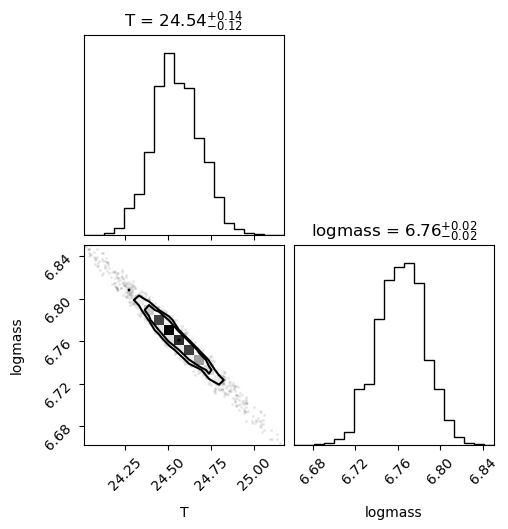

In [14]:
cornerplot(result)

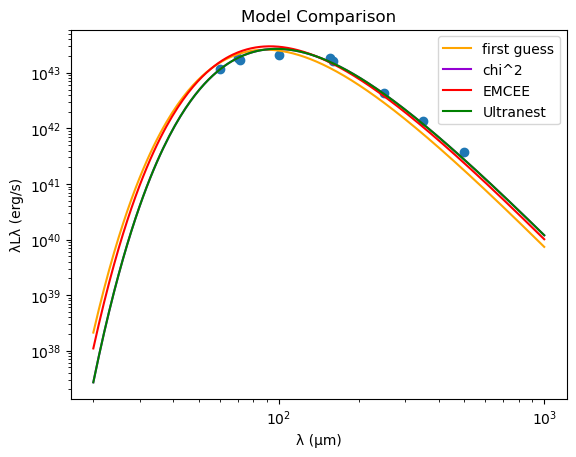

In [15]:
best_fit_params = result['maximum_likelihood']['point']

plt.scatter(x_data,y_data)
plt.ylabel('λLλ (erg/s)') 
plt.xlabel('λ (μm)') 
plt.yscale('log')
plt.xscale('log')


xaxis=np.linspace(20,1000,1000)
plt.plot(xaxis,grey_body_luminosity(xaxis,27, 6.5),color='orange',label='first guess')
plt.plot(xaxis,grey_body_luminosity(xaxis,chi2_values_fit[0],chi2_values_fit[1]),color='darkviolet',label='chi^2')
plt.plot(xaxis,grey_body_luminosity(xaxis,emcee_trace[:,0].mean(),emcee_trace[:,1].mean()),color='red',label='EMCEE')
plt.plot(xaxis, grey_body_luminosity(xaxis, best_fit_params[0], best_fit_params[1]),color="green", label='Ultranest')
plt.title("Model Comparison")
plt.legend()
plt.show()

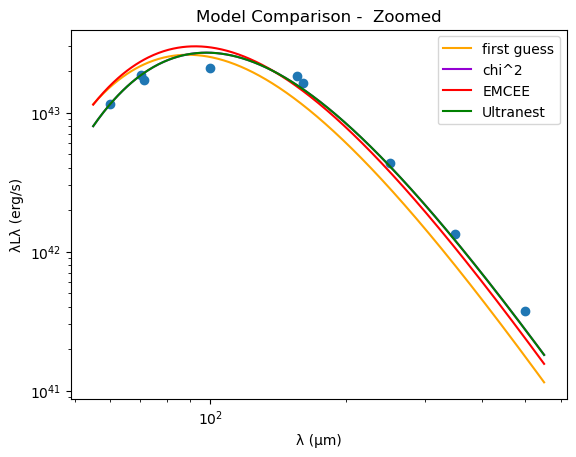

In [16]:
plt.scatter(x_data,y_data)
plt.ylabel('λLλ (erg/s)') 
plt.xlabel('λ (μm)') 
plt.yscale('log')
plt.xscale('log')


xaxis=np.linspace(55,550,1000)
plt.plot(xaxis,grey_body_luminosity(xaxis,27, 6.5),color='orange',label='first guess')
plt.plot(xaxis,grey_body_luminosity(xaxis,chi2_values_fit[0],chi2_values_fit[1]),color='darkviolet',label='chi^2')
plt.plot(xaxis,grey_body_luminosity(xaxis,emcee_trace[:,0].mean(),emcee_trace[:,1].mean()),color='red',label='EMCEE')
plt.plot(xaxis, grey_body_luminosity(xaxis, best_fit_params[0], best_fit_params[1]),color="green", label='Ultranest')
plt.title("Model Comparison -  Zoomed")
plt.legend()
plt.show()

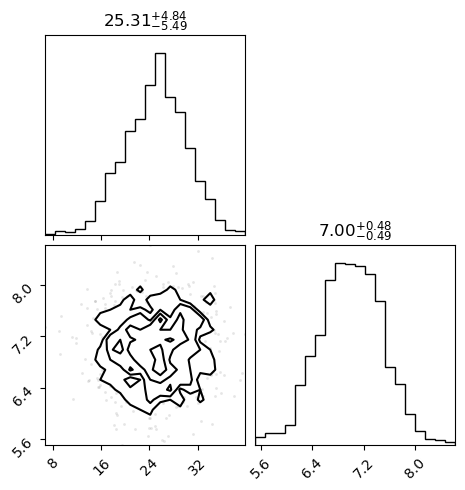

In [18]:
#Parameter Space cornerplot


p = [prior_transform(np.random.uniform(size=4)) for i in range(1000)]
corner.corner(np.array(p), show_titles=True, plot_density=False, quiet=True);